In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt

Using TensorFlow backend.


In [2]:
# Reproducibility
seed = 9 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [3]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###

def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [4]:
### RECEIVE 10,000 PIECES OF DATA ###

N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
# X_scale, X_test, Y_scale, Y_test = train_test_split(X_scale, Y_scale, test_size=0.15)

In [5]:
### FUNCTION TAKES HYPERPARAMETERS AND RETURNS COMPILED MODEL ###

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
    hp_regularizer = hp.Choice('regularizer_penalty', values=[1e-4, 1e-5, 1e-6])
    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=56, max_value=200, step=4), kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
#     model.add(keras.layers.Dense(hp.Int('hidden_units', min_value=10, max_value=320, step=1), kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
#         model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=10, max_value=320, step=1)))
#     SHOULD DROPOUT BE INCLUDED??
#     model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer)))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error', 'mean_absolute_error'])
#     if hp.Boolean('adam'):
#         model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                     loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
#     else:
#         model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
#                     loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [6]:
### CREATE HYPERBAND TUNER ###

# The maximum number of epochs to train one model. It is recommended to 
# set this to a value slightly higher than the expected time 
# to convergence for your largest Model, and to use early stopping 
# during training
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_mean_squared_error', 'min'),
                     max_epochs=100,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers',
                     overwrite=False,
                     seed=8)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5)

In [7]:
### SEARCHING FOR THE ANN LAYOUT THAT ACCOMPLISHES THE HYPERPARAMTER GOALS ###

start_time = time.time()
# tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.15, callbacks=[stop_early], verbose=2)
tuner.search(X_scale, Y_scale, validation_split=0.2, callbacks=[stop_early], verbose=2)
searching_time = time.time() - start_time
print(searching_time)

Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1237 - mean_squared_error: 0.1081 - mean_absolute_error: 0.2945 - val_loss: 0.0613 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1773
Epoch 2/2
8500/8500 - 1s - loss: 0.0485 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1318 - val_loss: 0.0430 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.1041


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0274 - mean_squared_error: 0.0234 - mean_absolute_error: 0.0952 - val_loss: 0.0067 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0323
Epoch 2/2
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0308 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0283


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2082 - mean_squared_error: 0.2065 - mean_absolute_error: 0.4263 - val_loss: 0.1882 - val_mean_squared_error: 0.1865 - val_mean_absolute_error: 0.4031
Epoch 2/2
8500/8500 - 1s - loss: 0.1713 - mean_squared_error: 0.1696 - mean_absolute_error: 0.3832 - val_loss: 0.1545 - val_mean_squared_error: 0.1528 - val_mean_absolute_error: 0.3625


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0893 - mean_squared_error: 0.0891 - mean_absolute_error: 0.2602 - val_loss: 0.0214 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1288
Epoch 2/2
8500/8500 - 1s - loss: 0.0101 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0860 - val_loss: 0.0049 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0592


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0177 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0553 - val_loss: 0.0061 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0243
Epoch 2/2
8500/8500 - 1s - loss: 0.0064 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0283 - val_loss: 0.0068 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0306


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2177 - mean_squared_error: 0.2176 - mean_absolute_error: 0.4375 - val_loss: 0.2014 - val_mean_squared_error: 0.2013 - val_mean_absolute_error: 0.4195
Epoch 2/2
8500/8500 - 1s - loss: 0.1908 - mean_squared_error: 0.1907 - mean_absolute_error: 0.4067 - val_loss: 0.1820 - val_mean_squared_error: 0.1819 - val_mean_absolute_error: 0.3961


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1999 - mean_squared_error: 0.1998 - mean_absolute_error: 0.4209 - val_loss: 0.1821 - val_mean_squared_error: 0.1820 - val_mean_absolute_error: 0.3983
Epoch 2/2
8500/8500 - 1s - loss: 0.1675 - mean_squared_error: 0.1674 - mean_absolute_error: 0.3827 - val_loss: 0.1529 - val_mean_squared_error: 0.1528 - val_mean_absolute_error: 0.3652


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0211 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0751 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0294
Epoch 2/2
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0293


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2034 - mean_squared_error: 0.2015 - mean_absolute_error: 0.4189 - val_loss: 0.1831 - val_mean_squared_error: 0.1812 - val_mean_absolute_error: 0.3959
Epoch 2/2
8500/8500 - 1s - loss: 0.1641 - mean_squared_error: 0.1622 - mean_absolute_error: 0.3738 - val_loss: 0.1451 - val_mean_squared_error: 0.1432 - val_mean_absolute_error: 0.3493


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1993 - mean_squared_error: 0.1979 - mean_absolute_error: 0.4210 - val_loss: 0.1798 - val_mean_squared_error: 0.1785 - val_mean_absolute_error: 0.3956
Epoch 2/2
8500/8500 - 1s - loss: 0.1630 - mean_squared_error: 0.1617 - mean_absolute_error: 0.3769 - val_loss: 0.1465 - val_mean_squared_error: 0.1450 - val_mean_absolute_error: 0.3569


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2216 - mean_squared_error: 0.2040 - mean_absolute_error: 0.4248 - val_loss: 0.2027 - val_mean_squared_error: 0.1852 - val_mean_absolute_error: 0.4014
Epoch 2/2
8500/8500 - 1s - loss: 0.1877 - mean_squared_error: 0.1701 - mean_absolute_error: 0.3842 - val_loss: 0.1711 - val_mean_squared_error: 0.1533 - val_mean_absolute_error: 0.3635


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0933 - mean_squared_error: 0.0914 - mean_absolute_error: 0.2648 - val_loss: 0.0257 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1339
Epoch 2/2
8500/8500 - 1s - loss: 0.0142 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0904 - val_loss: 0.0092 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0637


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.2117 - mean_squared_error: 0.2107 - mean_absolute_error: 0.4271 - val_loss: 0.1990 - val_mean_squared_error: 0.1979 - val_mean_absolute_error: 0.4129
Epoch 2/2
8500/8500 - 1s - loss: 0.1890 - mean_squared_error: 0.1880 - mean_absolute_error: 0.4024 - val_loss: 0.1804 - val_mean_squared_error: 0.1793 - val_mean_absolute_error: 0.3927


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.1486 - mean_squared_error: 0.1372 - mean_absolute_error: 0.3376 - val_loss: 0.0901 - val_mean_squared_error: 0.0751 - val_mean_absolute_error: 0.2433
Epoch 2/2
8500/8500 - 1s - loss: 0.0677 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1907 - val_loss: 0.0527 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1486


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0206 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0726 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0292
Epoch 2/2
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0761 - mean_squared_error: 0.0732 - mean_absolute_error: 0.2189 - val_loss: 0.0162 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0892
Epoch 2/2
8500/8500 - 1s - loss: 0.0097 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0584 - val_loss: 0.0071 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0396


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1269 - mean_squared_error: 0.1068 - mean_absolute_error: 0.2815 - val_loss: 0.0696 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1706
Epoch 2/2
8500/8500 - 1s - loss: 0.0532 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1225 - val_loss: 0.0448 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0906


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.1286 - mean_squared_error: 0.1141 - mean_absolute_error: 0.3038 - val_loss: 0.0687 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1961
Epoch 2/2
8500/8500 - 1s - loss: 0.0522 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1461 - val_loss: 0.0442 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1126


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.1240 - mean_squared_error: 0.1239 - mean_absolute_error: 0.3175 - val_loss: 0.0572 - val_mean_squared_error: 0.0570 - val_mean_absolute_error: 0.2093
Epoch 2/2
8500/8500 - 1s - loss: 0.0305 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1480 - val_loss: 0.0140 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.1019


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2153 - mean_squared_error: 0.1925 - mean_absolute_error: 0.4121 - val_loss: 0.1888 - val_mean_squared_error: 0.1660 - val_mean_absolute_error: 0.3801
Epoch 2/2
8500/8500 - 1s - loss: 0.1649 - mean_squared_error: 0.1417 - mean_absolute_error: 0.3499 - val_loss: 0.1420 - val_mean_squared_error: 0.1183 - val_mean_absolute_error: 0.3158


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0160 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0602 - val_loss: 0.0012 - val_mean_squared_error: 6.4088e-04 - val_mean_absolute_error: 0.0169
Epoch 2/2
8500/8500 - 1s - loss: 0.0021 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0226 - val_loss: 0.0024 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0242


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0200 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0627 - val_loss: 0.0059 - val_mean_squared_error: 9.7343e-04 - val_mean_absolute_error: 0.0236
Epoch 2/2
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0279 - val_loss: 0.0060 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0263


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1916 - mean_squared_error: 0.1891 - mean_absolute_error: 0.4084 - val_loss: 0.1618 - val_mean_squared_error: 0.1593 - val_mean_absolute_error: 0.3735
Epoch 2/2
8500/8500 - 1s - loss: 0.1345 - mean_squared_error: 0.1319 - mean_absolute_error: 0.3374 - val_loss: 0.1089 - val_mean_squared_error: 0.1062 - val_mean_absolute_error: 0.2982


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0182 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0743 - val_loss: 0.0013 - val_mean_squared_error: 6.4900e-04 - val_mean_absolute_error: 0.0200
Epoch 2/2
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 6.0095e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0011 - val_mean_squared_error: 3.8999e-04 - val_mean_absolute_error: 0.0147


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0534 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1025 - val_loss: 0.0392 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0721
Epoch 2/2
8500/8500 - 1s - loss: 0.0397 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0728 - val_loss: 0.0401 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0750


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1167 - mean_squared_error: 0.1165 - mean_absolute_error: 0.3059 - val_loss: 0.0440 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1847
Epoch 2/2
8500/8500 - 1s - loss: 0.0214 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1252 - val_loss: 0.0093 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0838


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0232 - mean_squared_error: 0.0227 - mean_absolute_error: 0.0813 - val_loss: 0.0010 - val_mean_squared_error: 4.9103e-04 - val_mean_absolute_error: 0.0164
Epoch 2/2
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 8.7877e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0013 - val_mean_squared_error: 6.9938e-04 - val_mean_absolute_error: 0.0166


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0520 - mean_squared_error: 0.0187 - mean_absolute_error: 0.0962 - val_loss: 0.0393 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0720
Epoch 2/2
8500/8500 - 1s - loss: 0.0399 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0731 - val_loss: 0.0403 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0746


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1047 - mean_squared_error: 0.1029 - mean_absolute_error: 0.2846 - val_loss: 0.0347 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1585
Epoch 2/2
8500/8500 - 1s - loss: 0.0183 - mean_squared_error: 0.0151 - mean_absolute_error: 0.1070 - val_loss: 0.0106 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0738


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0686 - mean_squared_error: 0.0654 - mean_absolute_error: 0.2030 - val_loss: 0.0119 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0733
Epoch 2/2
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0496 - val_loss: 0.0066 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0343


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2046 - mean_squared_error: 0.2045 - mean_absolute_error: 0.4255 - val_loss: 0.1870 - val_mean_squared_error: 0.1869 - val_mean_absolute_error: 0.4037
Epoch 2/2
8500/8500 - 1s - loss: 0.1728 - mean_squared_error: 0.1727 - mean_absolute_error: 0.3883 - val_loss: 0.1587 - val_mean_squared_error: 0.1586 - val_mean_absolute_error: 0.3720


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2207 - mean_squared_error: 0.2042 - mean_absolute_error: 0.4225 - val_loss: 0.2023 - val_mean_squared_error: 0.1859 - val_mean_absolute_error: 0.4013
Epoch 2/2
8500/8500 - 1s - loss: 0.1877 - mean_squared_error: 0.1712 - mean_absolute_error: 0.3846 - val_loss: 0.1726 - val_mean_squared_error: 0.1560 - val_mean_absolute_error: 0.3664


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.2174 - mean_squared_error: 0.2065 - mean_absolute_error: 0.4251 - val_loss: 0.2027 - val_mean_squared_error: 0.1919 - val_mean_absolute_error: 0.4084
Epoch 2/2
8500/8500 - 1s - loss: 0.1918 - mean_squared_error: 0.1810 - mean_absolute_error: 0.3967 - val_loss: 0.1819 - val_mean_squared_error: 0.1710 - val_mean_absolute_error: 0.3853


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0641 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1928 - val_loss: 0.0107 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0664
Epoch 2/2
8500/8500 - 1s - loss: 0.0079 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0463 - val_loss: 0.0066 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0328


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0192 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0689 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291
Epoch 2/2
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0303 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0293


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0527 - mean_squared_error: 0.0201 - mean_absolute_error: 0.0991 - val_loss: 0.0392 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0716
Epoch 2/2
8500/8500 - 1s - loss: 0.0397 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0729 - val_loss: 0.0400 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0743


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2212 - mean_squared_error: 0.2097 - mean_absolute_error: 0.4323 - val_loss: 0.2046 - val_mean_squared_error: 0.1932 - val_mean_absolute_error: 0.4110
Epoch 2/2
8500/8500 - 1s - loss: 0.1930 - mean_squared_error: 0.1816 - mean_absolute_error: 0.3984 - val_loss: 0.1809 - val_mean_squared_error: 0.1694 - val_mean_absolute_error: 0.3842


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2131 - mean_squared_error: 0.1875 - mean_absolute_error: 0.4055 - val_loss: 0.1850 - val_mean_squared_error: 0.1594 - val_mean_absolute_error: 0.3735
Epoch 2/2
8500/8500 - 1s - loss: 0.1582 - mean_squared_error: 0.1321 - mean_absolute_error: 0.3379 - val_loss: 0.1343 - val_mean_squared_error: 0.1076 - val_mean_absolute_error: 0.3000


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0151 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0564 - val_loss: 0.0012 - val_mean_squared_error: 6.3041e-04 - val_mean_absolute_error: 0.0166
Epoch 2/2
8500/8500 - 1s - loss: 0.0024 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0241 - val_loss: 0.0033 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0282


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0526 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1167 - val_loss: 0.0411 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0898
Epoch 2/2
8500/8500 - 1s - loss: 0.0415 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0907 - val_loss: 0.0418 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0926


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1094 - mean_squared_error: 0.1077 - mean_absolute_error: 0.2923 - val_loss: 0.0398 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1702
Epoch 2/2
8500/8500 - 1s - loss: 0.0210 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1158 - val_loss: 0.0116 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0792


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0182 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0571 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0244
Epoch 2/2
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0280 - val_loss: 0.0061 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0271


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0887 - mean_squared_error: 0.0527 - mean_absolute_error: 0.1805 - val_loss: 0.0469 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0774
Epoch 2/2
8500/8500 - 1s - loss: 0.0435 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0728 - val_loss: 0.0409 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0701


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0958 - mean_squared_error: 0.0956 - mean_absolute_error: 0.2716 - val_loss: 0.0255 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1406
Epoch 2/2
8500/8500 - 1s - loss: 0.0119 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0935 - val_loss: 0.0055 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0638


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2068 - mean_squared_error: 0.2066 - mean_absolute_error: 0.4284 - val_loss: 0.1896 - val_mean_squared_error: 0.1895 - val_mean_absolute_error: 0.4061
Epoch 2/2
8500/8500 - 1s - loss: 0.1773 - mean_squared_error: 0.1771 - mean_absolute_error: 0.3928 - val_loss: 0.1650 - val_mean_squared_error: 0.1649 - val_mean_absolute_error: 0.3785


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1944 - mean_squared_error: 0.1942 - mean_absolute_error: 0.4136 - val_loss: 0.1704 - val_mean_squared_error: 0.1702 - val_mean_absolute_error: 0.3834
Epoch 2/2
8500/8500 - 1s - loss: 0.1486 - mean_squared_error: 0.1484 - mean_absolute_error: 0.3573 - val_loss: 0.1261 - val_mean_squared_error: 0.1259 - val_mean_absolute_error: 0.3265


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0842 - mean_squared_error: 0.0814 - mean_absolute_error: 0.2339 - val_loss: 0.0196 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1016
Epoch 2/2
8500/8500 - 1s - loss: 0.0106 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0642 - val_loss: 0.0071 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0421


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 3s - loss: 0.1898 - mean_squared_error: 0.1895 - mean_absolute_error: 0.4081 - val_loss: 0.1599 - val_mean_squared_error: 0.1597 - val_mean_absolute_error: 0.3732
Epoch 2/2
8500/8500 - 1s - loss: 0.1315 - mean_squared_error: 0.1312 - mean_absolute_error: 0.3366 - val_loss: 0.1045 - val_mean_squared_error: 0.1042 - val_mean_absolute_error: 0.2958


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1062 - mean_squared_error: 0.0793 - mean_absolute_error: 0.2340 - val_loss: 0.0498 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1085
Epoch 2/2
8500/8500 - 1s - loss: 0.0439 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0833 - val_loss: 0.0412 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0713


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2002 - mean_squared_error: 0.1989 - mean_absolute_error: 0.4193 - val_loss: 0.1827 - val_mean_squared_error: 0.1814 - val_mean_absolute_error: 0.3979
Epoch 2/2
8500/8500 - 1s - loss: 0.1666 - mean_squared_error: 0.1653 - mean_absolute_error: 0.3806 - val_loss: 0.1512 - val_mean_squared_error: 0.1499 - val_mean_absolute_error: 0.3624


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2231 - mean_squared_error: 0.2117 - mean_absolute_error: 0.4344 - val_loss: 0.2065 - val_mean_squared_error: 0.1952 - val_mean_absolute_error: 0.4122
Epoch 2/2
8500/8500 - 1s - loss: 0.1947 - mean_squared_error: 0.1834 - mean_absolute_error: 0.3994 - val_loss: 0.1838 - val_mean_squared_error: 0.1725 - val_mean_absolute_error: 0.3869


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2217 - mean_squared_error: 0.2102 - mean_absolute_error: 0.4317 - val_loss: 0.2061 - val_mean_squared_error: 0.1946 - val_mean_absolute_error: 0.4116
Epoch 2/2
8500/8500 - 1s - loss: 0.1943 - mean_squared_error: 0.1829 - mean_absolute_error: 0.3988 - val_loss: 0.1833 - val_mean_squared_error: 0.1718 - val_mean_absolute_error: 0.3861


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2065 - mean_squared_error: 0.2048 - mean_absolute_error: 0.4242 - val_loss: 0.1855 - val_mean_squared_error: 0.1838 - val_mean_absolute_error: 0.3990
Epoch 2/2
8500/8500 - 1s - loss: 0.1691 - mean_squared_error: 0.1673 - mean_absolute_error: 0.3800 - val_loss: 0.1514 - val_mean_squared_error: 0.1497 - val_mean_absolute_error: 0.3578


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0515 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1137 - val_loss: 0.0412 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0898
Epoch 2/2
8500/8500 - 1s - loss: 0.0416 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0908 - val_loss: 0.0420 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0930


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1134 - mean_squared_error: 0.0961 - mean_absolute_error: 0.2747 - val_loss: 0.0544 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1559
Epoch 2/2
8500/8500 - 1s - loss: 0.0458 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1182 - val_loss: 0.0424 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0972


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2075 - mean_squared_error: 0.2062 - mean_absolute_error: 0.4269 - val_loss: 0.1896 - val_mean_squared_error: 0.1883 - val_mean_absolute_error: 0.4055
Epoch 2/2
8500/8500 - 1s - loss: 0.1751 - mean_squared_error: 0.1738 - mean_absolute_error: 0.3899 - val_loss: 0.1603 - val_mean_squared_error: 0.1590 - val_mean_absolute_error: 0.3725


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1044 - mean_squared_error: 0.1042 - mean_absolute_error: 0.2866 - val_loss: 0.0340 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1616
Epoch 2/2
8500/8500 - 1s - loss: 0.0161 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1088 - val_loss: 0.0072 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0736


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0713 - mean_squared_error: 0.0710 - mean_absolute_error: 0.2140 - val_loss: 0.0103 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0818
Epoch 2/2
8500/8500 - 1s - loss: 0.0047 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0527 - val_loss: 0.0022 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0337


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0221 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0779 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0296
Epoch 2/2
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0293


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0144 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0618 - val_loss: 0.0012 - val_mean_squared_error: 5.2202e-04 - val_mean_absolute_error: 0.0175
Epoch 2/2
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 7.5959e-04 - mean_absolute_error: 0.0186 - val_loss: 0.0011 - val_mean_squared_error: 3.9294e-04 - val_mean_absolute_error: 0.0142


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0534 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1189 - val_loss: 0.0411 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0898
Epoch 2/2
8500/8500 - 1s - loss: 0.0414 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0907 - val_loss: 0.0417 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0924


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1910 - mean_squared_error: 0.1908 - mean_absolute_error: 0.4101 - val_loss: 0.1661 - val_mean_squared_error: 0.1658 - val_mean_absolute_error: 0.3794
Epoch 2/2
8500/8500 - 1s - loss: 0.1410 - mean_squared_error: 0.1407 - mean_absolute_error: 0.3483 - val_loss: 0.1166 - val_mean_squared_error: 0.1164 - val_mean_absolute_error: 0.3133


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.2043 - mean_squared_error: 0.2031 - mean_absolute_error: 0.4240 - val_loss: 0.1889 - val_mean_squared_error: 0.1876 - val_mean_absolute_error: 0.4042
Epoch 2/2
8500/8500 - 1s - loss: 0.1751 - mean_squared_error: 0.1739 - mean_absolute_error: 0.3892 - val_loss: 0.1625 - val_mean_squared_error: 0.1612 - val_mean_absolute_error: 0.3746


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2000 - mean_squared_error: 0.1986 - mean_absolute_error: 0.4202 - val_loss: 0.1816 - val_mean_squared_error: 0.1803 - val_mean_absolute_error: 0.3975
Epoch 2/2
8500/8500 - 1s - loss: 0.1654 - mean_squared_error: 0.1640 - mean_absolute_error: 0.3797 - val_loss: 0.1493 - val_mean_squared_error: 0.1480 - val_mean_absolute_error: 0.3605


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2003 - mean_squared_error: 0.2002 - mean_absolute_error: 0.4227 - val_loss: 0.1811 - val_mean_squared_error: 0.1810 - val_mean_absolute_error: 0.3985
Epoch 2/2
8500/8500 - 1s - loss: 0.1647 - mean_squared_error: 0.1645 - mean_absolute_error: 0.3803 - val_loss: 0.1484 - val_mean_squared_error: 0.1483 - val_mean_absolute_error: 0.3612


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1905 - mean_squared_error: 0.1902 - mean_absolute_error: 0.4089 - val_loss: 0.1623 - val_mean_squared_error: 0.1620 - val_mean_absolute_error: 0.3762
Epoch 2/2
8500/8500 - 1s - loss: 0.1362 - mean_squared_error: 0.1360 - mean_absolute_error: 0.3428 - val_loss: 0.1096 - val_mean_squared_error: 0.1094 - val_mean_absolute_error: 0.3045


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0570 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1303 - val_loss: 0.0410 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0907
Epoch 2/2
8500/8500 - 1s - loss: 0.0412 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0905 - val_loss: 0.0412 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0906


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0206 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0659 - val_loss: 0.0058 - val_mean_squared_error: 9.2900e-04 - val_mean_absolute_error: 0.0234
Epoch 2/2
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0259 - val_loss: 0.0057 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0245


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0768 - mean_squared_error: 0.0738 - mean_absolute_error: 0.2200 - val_loss: 0.0150 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0867
Epoch 2/2
8500/8500 - 1s - loss: 0.0092 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0569 - val_loss: 0.0070 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0389


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0186 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0590 - val_loss: 0.0061 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0250
Epoch 2/2
8500/8500 - 1s - loss: 0.0064 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0283 - val_loss: 0.0064 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0285


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0556 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1093 - val_loss: 0.0390 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0712
Epoch 2/2
8500/8500 - 1s - loss: 0.0393 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0723 - val_loss: 0.0397 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0748


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0515 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0924 - val_loss: 0.0397 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0726
Epoch 2/2
8500/8500 - 1s - loss: 0.0404 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0736 - val_loss: 0.0407 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0751


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.1402 - mean_squared_error: 0.1401 - mean_absolute_error: 0.3400 - val_loss: 0.0783 - val_mean_squared_error: 0.0782 - val_mean_absolute_error: 0.2455
Epoch 2/2
8500/8500 - 1s - loss: 0.0489 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1870 - val_loss: 0.0276 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1391


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.0585 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1342 - val_loss: 0.0409 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0905
Epoch 2/2
8500/8500 - 1s - loss: 0.0412 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0905 - val_loss: 0.0412 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0906


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0572 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1128 - val_loss: 0.0389 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0711
Epoch 2/2
8500/8500 - 1s - loss: 0.0392 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0722 - val_loss: 0.0397 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0745


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2250 - mean_squared_error: 0.2152 - mean_absolute_error: 0.4365 - val_loss: 0.2106 - val_mean_squared_error: 0.2008 - val_mean_absolute_error: 0.4194
Epoch 2/2
8500/8500 - 2s - loss: 0.2005 - mean_squared_error: 0.1907 - mean_absolute_error: 0.4071 - val_loss: 0.1921 - val_mean_squared_error: 0.1824 - val_mean_absolute_error: 0.3967


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 3s - loss: 0.0958 - mean_squared_error: 0.0647 - mean_absolute_error: 0.2058 - val_loss: 0.0474 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0896
Epoch 2/2
8500/8500 - 1s - loss: 0.0436 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0763 - val_loss: 0.0412 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0706


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1026 - mean_squared_error: 0.1025 - mean_absolute_error: 0.2834 - val_loss: 0.0318 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1563
Epoch 2/2
8500/8500 - 1s - loss: 0.0148 - mean_squared_error: 0.0145 - mean_absolute_error: 0.1041 - val_loss: 0.0066 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0705


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1362 - mean_squared_error: 0.1350 - mean_absolute_error: 0.3336 - val_loss: 0.0703 - val_mean_squared_error: 0.0686 - val_mean_absolute_error: 0.2304
Epoch 2/2
8500/8500 - 1s - loss: 0.0426 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1712 - val_loss: 0.0234 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1231


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0207 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0728 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0293
Epoch 2/2
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2141 - mean_squared_error: 0.2016 - mean_absolute_error: 0.4225 - val_loss: 0.1976 - val_mean_squared_error: 0.1851 - val_mean_absolute_error: 0.4016
Epoch 2/2
8500/8500 - 1s - loss: 0.1831 - mean_squared_error: 0.1704 - mean_absolute_error: 0.3859 - val_loss: 0.1694 - val_mean_squared_error: 0.1566 - val_mean_absolute_error: 0.3700


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.2254 - mean_squared_error: 0.2140 - mean_absolute_error: 0.4370 - val_loss: 0.2087 - val_mean_squared_error: 0.1974 - val_mean_absolute_error: 0.4160
Epoch 2/2
8500/8500 - 1s - loss: 0.1964 - mean_squared_error: 0.1851 - mean_absolute_error: 0.4018 - val_loss: 0.1866 - val_mean_squared_error: 0.1752 - val_mean_absolute_error: 0.3899


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0906 - mean_squared_error: 0.0886 - mean_absolute_error: 0.2599 - val_loss: 0.0242 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1298
Epoch 2/2
8500/8500 - 1s - loss: 0.0137 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0882 - val_loss: 0.0090 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0625


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1002 - mean_squared_error: 0.0706 - mean_absolute_error: 0.2178 - val_loss: 0.0484 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0971
Epoch 2/2
8500/8500 - 1s - loss: 0.0440 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0791 - val_loss: 0.0415 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0708


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 1s - loss: 0.1297 - mean_squared_error: 0.1284 - mean_absolute_error: 0.3246 - val_loss: 0.0631 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.2187
Epoch 2/2
8500/8500 - 1s - loss: 0.0365 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1580 - val_loss: 0.0194 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1112


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0184 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0584 - val_loss: 0.0061 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0247
Epoch 2/2
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0279 - val_loss: 0.0061 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0269


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0534 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1195 - val_loss: 0.0411 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0900
Epoch 2/2
8500/8500 - 1s - loss: 0.0414 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0907 - val_loss: 0.0416 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0919


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0556 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1255 - val_loss: 0.0410 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0903
Epoch 2/2
8500/8500 - 1s - loss: 0.0413 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0906 - val_loss: 0.0413 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0912


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0776 - mean_squared_error: 0.0773 - mean_absolute_error: 0.2271 - val_loss: 0.0143 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0950
Epoch 2/2
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0599 - val_loss: 0.0028 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0390


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0545 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1228 - val_loss: 0.0410 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0901
Epoch 2/2
8500/8500 - 1s - loss: 0.0413 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0906 - val_loss: 0.0414 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0914


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0122 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0478 - val_loss: 0.0022 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0229
Epoch 2/2
8500/8500 - 1s - loss: 0.0073 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0385 - val_loss: 0.0223 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.0629


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0197 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0613 - val_loss: 0.0060 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0241
Epoch 2/2
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0273 - val_loss: 0.0058 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0248


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0541 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1038 - val_loss: 0.0391 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0714
Epoch 2/2
8500/8500 - 1s - loss: 0.0395 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0725 - val_loss: 0.0400 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0748


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1059 - mean_squared_error: 0.0797 - mean_absolute_error: 0.2341 - val_loss: 0.0506 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1109
Epoch 2/2
8500/8500 - 1s - loss: 0.0443 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0850 - val_loss: 0.0410 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0718


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1210 - mean_squared_error: 0.1051 - mean_absolute_error: 0.2902 - val_loss: 0.0607 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1756
Epoch 2/2
8500/8500 - 1s - loss: 0.0485 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1313 - val_loss: 0.0430 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.1035


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.1926 - mean_squared_error: 0.1900 - mean_absolute_error: 0.4097 - val_loss: 0.1627 - val_mean_squared_error: 0.1601 - val_mean_absolute_error: 0.3733
Epoch 2/2
8500/8500 - 1s - loss: 0.1343 - mean_squared_error: 0.1316 - mean_absolute_error: 0.3366 - val_loss: 0.1073 - val_mean_squared_error: 0.1045 - val_mean_absolute_error: 0.2962


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0523 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1160 - val_loss: 0.0412 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0900
Epoch 2/2
8500/8500 - 1s - loss: 0.0415 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0908 - val_loss: 0.0420 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0929


Train on 8500 samples, validate on 1500 samples
Epoch 1/2
8500/8500 - 2s - loss: 0.0935 - mean_squared_error: 0.0933 - mean_absolute_error: 0.2679 - val_loss: 0.0248 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1382
Epoch 2/2
8500/8500 - 1s - loss: 0.0115 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0920 - val_loss: 0.0054 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0631


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0187 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0751 - val_loss: 0.0013 - val_mean_squared_error: 6.3997e-04 - val_mean_absolute_error: 0.0198
Epoch 4/4
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 5.8876e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0011 - val_mean_squared_error: 3.9440e-04 - val_mean_absolute_error: 0.0147


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0147 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0632 - val_loss: 0.0012 - val_mean_squared_error: 5.0185e-04 - val_mean_absolute_error: 0.0175
Epoch 4/4
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 7.1298e-04 - mean_absolute_error: 0.0183 - val_loss: 0.0012 - val_mean_squared_error: 4.6633e-04 - val_mean_absolute_error: 0.0151


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0234 - mean_squared_error: 0.0230 - mean_absolute_error: 0.0826 - val_loss: 0.0010 - val_mean_squared_error: 5.0542e-04 - val_mean_absolute_error: 0.0166
Epoch 4/4
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 8.0888e-04 - mean_absolute_error: 0.0183 - val_loss: 0.0012 - val_mean_squared_error: 6.0732e-04 - val_mean_absolute_error: 0.0160


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0145 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0558 - val_loss: 0.0023 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0240
Epoch 4/4
8500/8500 - 1s - loss: 0.0030 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0277 - val_loss: 0.0039 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0310


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0163 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0611 - val_loss: 0.0012 - val_mean_squared_error: 6.1151e-04 - val_mean_absolute_error: 0.0166
Epoch 4/4
8500/8500 - 2s - loss: 0.0021 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0226 - val_loss: 0.0027 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0258


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0208 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0658 - val_loss: 0.0058 - val_mean_squared_error: 8.9458e-04 - val_mean_absolute_error: 0.0232
Epoch 4/4
8500/8500 - 1s - loss: 0.0059 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0249 - val_loss: 0.0058 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0244


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0196 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0620 - val_loss: 0.0059 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0241
Epoch 4/4
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0278 - val_loss: 0.0059 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0255


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0188 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0594 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0245
Epoch 4/4
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0281 - val_loss: 0.0060 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0265


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0175 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0552 - val_loss: 0.0062 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0258
Epoch 4/4
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0297 - val_loss: 0.0067 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0301


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0175 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0553 - val_loss: 0.0060 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0240
Epoch 4/4
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0273 - val_loss: 0.0060 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0262


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0190 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0593 - val_loss: 0.0060 - val_mean_squared_error: 9.9534e-04 - val_mean_absolute_error: 0.0237
Epoch 4/4
8500/8500 - 1s - loss: 0.0064 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0279 - val_loss: 0.0059 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0256


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0187 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0591 - val_loss: 0.0061 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0257
Epoch 4/4
8500/8500 - 1s - loss: 0.0064 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0286 - val_loss: 0.0062 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0271


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0281 - mean_squared_error: 0.0242 - mean_absolute_error: 0.0969 - val_loss: 0.0067 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0325
Epoch 4/4
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0309 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0196 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0698 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0292
Epoch 4/4
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0293


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0201 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0716 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0292
Epoch 4/4
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0293


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0213 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0758 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0295
Epoch 4/4
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0202 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0716 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291
Epoch 4/4
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0290


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0220 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0779 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0296
Epoch 4/4
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0290


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0122 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0480 - val_loss: 0.0023 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0227
Epoch 4/4
8500/8500 - 1s - loss: 0.0057 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0353 - val_loss: 0.0190 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0637


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0652 - mean_squared_error: 0.0617 - mean_absolute_error: 0.1947 - val_loss: 0.0106 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0665
Epoch 4/4
8500/8500 - 1s - loss: 0.0079 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0461 - val_loss: 0.0066 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0327


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0702 - mean_squared_error: 0.0699 - mean_absolute_error: 0.2119 - val_loss: 0.0097 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0793
Epoch 4/4
8500/8500 - 1s - loss: 0.0044 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0509 - val_loss: 0.0021 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0330


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0684 - mean_squared_error: 0.0651 - mean_absolute_error: 0.2021 - val_loss: 0.0116 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0719
Epoch 4/4
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0487 - val_loss: 0.0066 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0339


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0752 - mean_squared_error: 0.0722 - mean_absolute_error: 0.2171 - val_loss: 0.0147 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0855
Epoch 4/4
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0555 - val_loss: 0.0068 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0380


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0791 - mean_squared_error: 0.0789 - mean_absolute_error: 0.2304 - val_loss: 0.0152 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0986
Epoch 4/4
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0617 - val_loss: 0.0028 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0395


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0755 - mean_squared_error: 0.0726 - mean_absolute_error: 0.2182 - val_loss: 0.0153 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0872
Epoch 4/4
8500/8500 - 1s - loss: 0.0093 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0573 - val_loss: 0.0070 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0393


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0803 - mean_squared_error: 0.0775 - mean_absolute_error: 0.2272 - val_loss: 0.0191 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0990
Epoch 4/4
8500/8500 - 1s - loss: 0.0107 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0640 - val_loss: 0.0073 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0425


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0897 - mean_squared_error: 0.0895 - mean_absolute_error: 0.2610 - val_loss: 0.0216 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1295
Epoch 4/4
8500/8500 - 1s - loss: 0.0101 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0864 - val_loss: 0.0049 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0596


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0921 - mean_squared_error: 0.0901 - mean_absolute_error: 0.2623 - val_loss: 0.0244 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1305
Epoch 4/4
8500/8500 - 1s - loss: 0.0137 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0886 - val_loss: 0.0090 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0626


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0958 - mean_squared_error: 0.0956 - mean_absolute_error: 0.2713 - val_loss: 0.0252 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1396
Epoch 4/4
8500/8500 - 1s - loss: 0.0117 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0927 - val_loss: 0.0055 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0635


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0924 - mean_squared_error: 0.0905 - mean_absolute_error: 0.2632 - val_loss: 0.0253 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1332
Epoch 4/4
8500/8500 - 1s - loss: 0.0141 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0902 - val_loss: 0.0091 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0636


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0948 - mean_squared_error: 0.0946 - mean_absolute_error: 0.2705 - val_loss: 0.0255 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1407
Epoch 4/4
8500/8500 - 1s - loss: 0.0119 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0938 - val_loss: 0.0056 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0641


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0896 - mean_squared_error: 0.0537 - mean_absolute_error: 0.1821 - val_loss: 0.0469 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0774
Epoch 4/4
8500/8500 - 1s - loss: 0.0435 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0729 - val_loss: 0.0409 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0701


Train on 8500 samples, validate on 1500 samples
Epoch 3/4
8500/8500 - 2s - loss: 0.0955 - mean_squared_error: 0.0643 - mean_absolute_error: 0.2055 - val_loss: 0.0475 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0896
Epoch 4/4
8500/8500 - 1s - loss: 0.0437 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0764 - val_loss: 0.0413 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0706


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0175 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0722 - val_loss: 0.0012 - val_mean_squared_error: 6.0432e-04 - val_mean_absolute_error: 0.0193
Epoch 6/12
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 5.8453e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0011 - val_mean_squared_error: 3.7097e-04 - val_mean_absolute_error: 0.0143
Epoch 7/12
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 4.1800e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0010 - val_mean_squared_error: 2.7448e-04 - val_mean_absolute_error: 0.0123
Epoch 8/12
8500/8500 - 1s - loss: 0.0012 - mean_squared_error: 5.1214e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0010 - val_mean_squared_error: 2.6826e-04 - val_mean_absolute_error: 0.0122
Epoch 9/12
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 5.7118e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0012 - val_mean_squared_error: 4.8771e-04 - val_mean_absolute_

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0145 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0623 - val_loss: 0.0012 - val_mean_squared_error: 5.0466e-04 - val_mean_absolute_error: 0.0174
Epoch 6/12
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 7.7256e-04 - mean_absolute_error: 0.0187 - val_loss: 0.0011 - val_mean_squared_error: 4.0502e-04 - val_mean_absolute_error: 0.0144
Epoch 7/12
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 5.4395e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0011 - val_mean_squared_error: 3.8812e-04 - val_mean_absolute_error: 0.0140
Epoch 8/12
8500/8500 - 1s - loss: 0.0030 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0222 - val_loss: 0.0015 - val_mean_squared_error: 6.7150e-04 - val_mean_absolute_error: 0.0152
Epoch 9/12
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 7.4053e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0013 - val_mean_squared_error: 5.8775e-04 - val_mean_absolute_erro

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0237 - mean_squared_error: 0.0233 - mean_absolute_error: 0.0828 - val_loss: 0.0011 - val_mean_squared_error: 5.5307e-04 - val_mean_absolute_error: 0.0170
Epoch 6/12
8500/8500 - 1s - loss: 0.0017 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0207 - val_loss: 0.0011 - val_mean_squared_error: 5.8190e-04 - val_mean_absolute_error: 0.0160
Epoch 7/12
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 7.6663e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0020 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0217
Epoch 8/12
8500/8500 - 1s - loss: 0.0020 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0220 - val_loss: 0.0022 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0240
Epoch 9/12
8500/8500 - 1s - loss: 0.0026 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0255 - val_loss: 0.0029 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0269
Epoch 10/1

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0166 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0616 - val_loss: 0.0011 - val_mean_squared_error: 4.9088e-04 - val_mean_absolute_error: 0.0154
Epoch 6/12
8500/8500 - 1s - loss: 0.0019 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0217 - val_loss: 0.0018 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0203
Epoch 7/12
8500/8500 - 1s - loss: 0.0028 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0044 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0333
Epoch 8/12
8500/8500 - 1s - loss: 0.0045 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0326 - val_loss: 0.0048 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0343
Epoch 9/12
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0403 - val_loss: 0.0124 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0501
Epoch 10/12
8500/8

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0206 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0657 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0246
Epoch 6/12
8500/8500 - 1s - loss: 0.0061 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0268 - val_loss: 0.0057 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0247
Epoch 7/12
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0263 - val_loss: 0.0063 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0285
Epoch 8/12
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0315 - val_loss: 0.0068 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0309
Epoch 9/12
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0353 - val_loss: 0.0099 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0407
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0180 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0569 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0242
Epoch 6/12
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0275 - val_loss: 0.0063 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0281
Epoch 7/12
8500/8500 - 1s - loss: 0.0066 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0298 - val_loss: 0.0079 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0348
Epoch 8/12
8500/8500 - 1s - loss: 0.0238 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0551 - val_loss: 0.0515 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.0773
Epoch 9/12
8500/8500 - 1s - loss: 0.0372 - mean_squared_error: 0.0201 - mean_absolute_error: 0.0567 - val_loss: 0.0244 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0437
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0181 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0574 - val_loss: 0.0061 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0248
Epoch 6/12
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0280 - val_loss: 0.0062 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0276
Epoch 7/12
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0306 - val_loss: 0.0080 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0352
Epoch 8/12
8500/8500 - 1s - loss: 0.0226 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0541 - val_loss: 0.0414 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.0667
Epoch 9/12
8500/8500 - 1s - loss: 0.0308 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0514 - val_loss: 0.0223 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0442
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0195 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0617 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0247
Epoch 6/12
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0276 - val_loss: 0.0059 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0258
Epoch 7/12
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0278 - val_loss: 0.0070 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0321
Epoch 8/12
8500/8500 - 1s - loss: 0.0116 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0422 - val_loss: 0.0190 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0534
Epoch 9/12
8500/8500 - 1s - loss: 0.0273 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0554 - val_loss: 0.0237 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0471
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0184 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0582 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0244
Epoch 6/12
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0275 - val_loss: 0.0062 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0274
Epoch 7/12
8500/8500 - 1s - loss: 0.0066 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0297 - val_loss: 0.0075 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0336
Epoch 8/12
8500/8500 - 1s - loss: 0.0100 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0402 - val_loss: 0.0165 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0515
Epoch 9/12
8500/8500 - 1s - loss: 0.0364 - mean_squared_error: 0.0239 - mean_absolute_error: 0.0635 - val_loss: 0.0275 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0476
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 1s - loss: 0.0281 - mean_squared_error: 0.0241 - mean_absolute_error: 0.0964 - val_loss: 0.0067 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0324
Epoch 6/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0308 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0283
Epoch 7/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0297 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0281
Epoch 8/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0297 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284
Epoch 9/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0294 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0189 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0584 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0242
Epoch 6/12
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0276 - val_loss: 0.0061 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0270
Epoch 7/12
8500/8500 - 1s - loss: 0.0065 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0292 - val_loss: 0.0077 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0348
Epoch 8/12
8500/8500 - 1s - loss: 0.0265 - mean_squared_error: 0.0185 - mean_absolute_error: 0.0578 - val_loss: 0.0596 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.0853
Epoch 9/12
8500/8500 - 1s - loss: 0.0354 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0546 - val_loss: 0.0238 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0439
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0180 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0733 - val_loss: 0.0013 - val_mean_squared_error: 6.2593e-04 - val_mean_absolute_error: 0.0195
Epoch 14/34
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 6.1266e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0011 - val_mean_squared_error: 3.8187e-04 - val_mean_absolute_error: 0.0145
Epoch 15/34
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 4.1210e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0010 - val_mean_squared_error: 2.7879e-04 - val_mean_absolute_error: 0.0125
Epoch 16/34
8500/8500 - 1s - loss: 0.0017 - mean_squared_error: 9.2442e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0012 - val_mean_squared_error: 4.3411e-04 - val_mean_absolute_error: 0.0143
Epoch 17/34
8500/8500 - 1s - loss: 0.0012 - mean_squared_error: 4.5783e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0013 - val_mean_squared_error: 5.3772e-04 - val_mean_abso

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0149 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0634 - val_loss: 0.0012 - val_mean_squared_error: 5.0819e-04 - val_mean_absolute_error: 0.0175
Epoch 14/34
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 7.0892e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0012 - val_mean_squared_error: 4.7267e-04 - val_mean_absolute_error: 0.0151
Epoch 15/34
8500/8500 - 1s - loss: 0.0012 - mean_squared_error: 5.1127e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0012 - val_mean_squared_error: 4.8574e-04 - val_mean_absolute_error: 0.0150
Epoch 16/34
8500/8500 - 1s - loss: 0.0022 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0209 - val_loss: 0.0017 - val_mean_squared_error: 9.3187e-04 - val_mean_absolute_error: 0.0185
Epoch 17/34
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 7.7182e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0015 - val_mean_squared_error: 7.6091e-04 - val_mean_absolute

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0160 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0600 - val_loss: 0.0012 - val_mean_squared_error: 5.9300e-04 - val_mean_absolute_error: 0.0163
Epoch 14/34
8500/8500 - 1s - loss: 0.0022 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0232 - val_loss: 0.0023 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0238
Epoch 15/34
8500/8500 - 1s - loss: 0.0030 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0272 - val_loss: 0.0050 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0360
Epoch 16/34
8500/8500 - 1s - loss: 0.0061 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0375 - val_loss: 0.0082 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0422
Epoch 17/34
8500/8500 - 1s - loss: 0.0157 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0517 - val_loss: 0.0210 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0569
Epoch 18/34
8

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0248 - mean_squared_error: 0.0243 - mean_absolute_error: 0.0854 - val_loss: 0.0011 - val_mean_squared_error: 5.2871e-04 - val_mean_absolute_error: 0.0169
Epoch 14/34
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 8.0443e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0012 - val_mean_squared_error: 6.0582e-04 - val_mean_absolute_error: 0.0159
Epoch 15/34
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 9.2977e-04 - mean_absolute_error: 0.0183 - val_loss: 0.0020 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0219
Epoch 16/34
8500/8500 - 1s - loss: 0.0020 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0223 - val_loss: 0.0018 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0210
Epoch 17/34
8500/8500 - 1s - loss: 0.0024 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0242 - val_loss: 0.0035 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0294
E

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0182 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0739 - val_loss: 0.0013 - val_mean_squared_error: 6.3067e-04 - val_mean_absolute_error: 0.0197
Epoch 36/100
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 5.9484e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0011 - val_mean_squared_error: 3.8838e-04 - val_mean_absolute_error: 0.0146
Epoch 37/100
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 4.0156e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0010 - val_mean_squared_error: 2.6982e-04 - val_mean_absolute_error: 0.0123
Epoch 38/100
8500/8500 - 1s - loss: 0.0024 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0201 - val_loss: 0.0012 - val_mean_squared_error: 3.9005e-04 - val_mean_absolute_error: 0.0131
Epoch 39/100
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 5.4541e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0011 - val_mean_squared_error: 3.5323e-04 - val_mean_abs

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0141 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0607 - val_loss: 0.0012 - val_mean_squared_error: 4.8478e-04 - val_mean_absolute_error: 0.0170
Epoch 36/100
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 7.1683e-04 - mean_absolute_error: 0.0181 - val_loss: 0.0021 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0222
Epoch 37/100
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 6.2098e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0012 - val_mean_squared_error: 4.7291e-04 - val_mean_absolute_error: 0.0148
Epoch 38/100
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 7.1333e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0013 - val_mean_squared_error: 5.2697e-04 - val_mean_absolute_error: 0.0154
Epoch 39/100
8500/8500 - 1s - loss: 0.0018 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0198 - val_loss: 0.0020 - val_mean_squared_error: 0.0013 - val_mean_absolute_er

Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0897 - mean_squared_error: 0.0895 - mean_absolute_error: 0.2498 - val_loss: 0.0248 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1231
Epoch 2/4
8500/8500 - 1s - loss: 0.0105 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0777 - val_loss: 0.0046 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0506
Epoch 3/4
8500/8500 - 1s - loss: 0.0030 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0397 - val_loss: 0.0019 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0298
Epoch 4/4
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 9.9110e-04 - mean_absolute_error: 0.0252 - val_loss: 0.0012 - val_mean_squared_error: 6.3665e-04 - val_mean_absolute_error: 0.0202


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0181 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0572 - val_loss: 0.0060 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0241
Epoch 2/4
8500/8500 - 1s - loss: 0.0064 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0280 - val_loss: 0.0063 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0279
Epoch 3/4
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0314 - val_loss: 0.0085 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0376
Epoch 4/4
8500/8500 - 1s - loss: 0.0208 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0526 - val_loss: 0.0420 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.0685


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2132 - mean_squared_error: 0.1872 - mean_absolute_error: 0.4047 - val_loss: 0.1836 - val_mean_squared_error: 0.1575 - val_mean_absolute_error: 0.3710
Epoch 2/4
8500/8500 - 1s - loss: 0.1562 - mean_squared_error: 0.1296 - mean_absolute_error: 0.3348 - val_loss: 0.1311 - val_mean_squared_error: 0.1038 - val_mean_absolute_error: 0.2953
Epoch 3/4
8500/8500 - 1s - loss: 0.1145 - mean_squared_error: 0.0865 - mean_absolute_error: 0.2650 - val_loss: 0.1016 - val_mean_squared_error: 0.0727 - val_mean_absolute_error: 0.2372
Epoch 4/4
8500/8500 - 1s - loss: 0.0915 - mean_squared_error: 0.0617 - mean_absolute_error: 0.2173 - val_loss: 0.0829 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1981


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 1s - loss: 0.0262 - mean_squared_error: 0.0258 - mean_absolute_error: 0.0988 - val_loss: 0.0015 - val_mean_squared_error: 9.5401e-04 - val_mean_absolute_error: 0.0250
Epoch 2/4
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 6.3398e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0010 - val_mean_squared_error: 3.2450e-04 - val_mean_absolute_error: 0.0139
Epoch 3/4
8500/8500 - 1s - loss: 0.0010 - mean_squared_error: 3.1100e-04 - mean_absolute_error: 0.0136 - val_loss: 9.6788e-04 - val_mean_squared_error: 2.3733e-04 - val_mean_absolute_error: 0.0118
Epoch 4/4
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 7.7044e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0010 - val_mean_squared_error: 2.8906e-04 - val_mean_absolute_error: 0.0129


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0935 - mean_squared_error: 0.0597 - mean_absolute_error: 0.1953 - val_loss: 0.0475 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0836
Epoch 2/4
8500/8500 - 1s - loss: 0.0438 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0745 - val_loss: 0.0412 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0703
Epoch 3/4
8500/8500 - 1s - loss: 0.0402 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0711 - val_loss: 0.0393 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0698
Epoch 4/4
8500/8500 - 1s - loss: 0.0391 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0708 - val_loss: 0.0389 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0713


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2243 - mean_squared_error: 0.2143 - mean_absolute_error: 0.4360 - val_loss: 0.2092 - val_mean_squared_error: 0.1993 - val_mean_absolute_error: 0.4172
Epoch 2/4
8500/8500 - 1s - loss: 0.1999 - mean_squared_error: 0.1901 - mean_absolute_error: 0.4066 - val_loss: 0.1911 - val_mean_squared_error: 0.1812 - val_mean_absolute_error: 0.3961
Epoch 3/4
8500/8500 - 1s - loss: 0.1823 - mean_squared_error: 0.1724 - mean_absolute_error: 0.3865 - val_loss: 0.1738 - val_mean_squared_error: 0.1637 - val_mean_absolute_error: 0.3767
Epoch 4/4
8500/8500 - 1s - loss: 0.1651 - mean_squared_error: 0.1549 - mean_absolute_error: 0.3665 - val_loss: 0.1568 - val_mean_squared_error: 0.1464 - val_mean_absolute_error: 0.3558


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0118 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0481 - val_loss: 0.0026 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0247
Epoch 2/4
8500/8500 - 1s - loss: 0.0133 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0481 - val_loss: 0.0512 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.0904
Epoch 3/4
8500/8500 - 1s - loss: 0.0443 - mean_squared_error: 0.0413 - mean_absolute_error: 0.0781 - val_loss: 0.0305 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.0629
Epoch 4/4
8500/8500 - 1s - loss: 0.0204 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0512 - val_loss: 0.0150 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0458


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0838 - mean_squared_error: 0.0810 - mean_absolute_error: 0.2341 - val_loss: 0.0194 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1016
Epoch 2/4
8500/8500 - 1s - loss: 0.0106 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0645 - val_loss: 0.0073 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0429
Epoch 3/4
8500/8500 - 1s - loss: 0.0066 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0358 - val_loss: 0.0061 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0289
Epoch 4/4
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0268 - val_loss: 0.0058 - val_mean_squared_error: 8.4458e-04 - val_mean_absolute_error: 0.0236


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0971 - mean_squared_error: 0.0673 - mean_absolute_error: 0.2112 - val_loss: 0.0477 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0939
Epoch 2/4
8500/8500 - 1s - loss: 0.0435 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0778 - val_loss: 0.0411 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0705
Epoch 3/4
8500/8500 - 1s - loss: 0.0403 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0711 - val_loss: 0.0394 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0698
Epoch 4/4
8500/8500 - 1s - loss: 0.0391 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0707 - val_loss: 0.0389 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0713


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2082 - mean_squared_error: 0.2081 - mean_absolute_error: 0.4311 - val_loss: 0.1906 - val_mean_squared_error: 0.1904 - val_mean_absolute_error: 0.4077
Epoch 2/4
8500/8500 - 1s - loss: 0.1775 - mean_squared_error: 0.1773 - mean_absolute_error: 0.3932 - val_loss: 0.1642 - val_mean_squared_error: 0.1641 - val_mean_absolute_error: 0.3777
Epoch 3/4
8500/8500 - 1s - loss: 0.1513 - mean_squared_error: 0.1512 - mean_absolute_error: 0.3629 - val_loss: 0.1380 - val_mean_squared_error: 0.1378 - val_mean_absolute_error: 0.3469
Epoch 4/4
8500/8500 - 1s - loss: 0.1257 - mean_squared_error: 0.1255 - mean_absolute_error: 0.3304 - val_loss: 0.1133 - val_mean_squared_error: 0.1131 - val_mean_absolute_error: 0.3133


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0599 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1378 - val_loss: 0.0409 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0907
Epoch 2/4
8500/8500 - 1s - loss: 0.0411 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0904 - val_loss: 0.0411 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0903
Epoch 3/4
8500/8500 - 1s - loss: 0.0412 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0907 - val_loss: 0.0411 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0896
Epoch 4/4
8500/8500 - 1s - loss: 0.0413 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0907 - val_loss: 0.0414 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0888


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0901 - mean_squared_error: 0.0875 - mean_absolute_error: 0.2459 - val_loss: 0.0267 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1203
Epoch 2/4
8500/8500 - 1s - loss: 0.0136 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0762 - val_loss: 0.0082 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0498
Epoch 3/4
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0403 - val_loss: 0.0062 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0317
Epoch 4/4
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0289 - val_loss: 0.0058 - val_mean_squared_error: 9.3133e-04 - val_mean_absolute_error: 0.0249


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1338 - mean_squared_error: 0.1162 - mean_absolute_error: 0.2956 - val_loss: 0.0801 - val_mean_squared_error: 0.0581 - val_mean_absolute_error: 0.1946
Epoch 2/4
8500/8500 - 1s - loss: 0.0610 - mean_squared_error: 0.0343 - mean_absolute_error: 0.1460 - val_loss: 0.0498 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1093
Epoch 3/4
8500/8500 - 1s - loss: 0.0456 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0935 - val_loss: 0.0433 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0836
Epoch 4/4
8500/8500 - 1s - loss: 0.0417 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0788 - val_loss: 0.0406 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0757


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1806 - mean_squared_error: 0.1803 - mean_absolute_error: 0.3976 - val_loss: 0.1436 - val_mean_squared_error: 0.1432 - val_mean_absolute_error: 0.3537
Epoch 2/4
8500/8500 - 1s - loss: 0.1109 - mean_squared_error: 0.1106 - mean_absolute_error: 0.3071 - val_loss: 0.0827 - val_mean_squared_error: 0.0824 - val_mean_absolute_error: 0.2597
Epoch 3/4
8500/8500 - 1s - loss: 0.0652 - mean_squared_error: 0.0648 - mean_absolute_error: 0.2259 - val_loss: 0.0505 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1951
Epoch 4/4
8500/8500 - 1s - loss: 0.0395 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1712 - val_loss: 0.0301 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1482


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0147 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0564 - val_loss: 0.0012 - val_mean_squared_error: 6.0747e-04 - val_mean_absolute_error: 0.0164
Epoch 2/4
8500/8500 - 1s - loss: 0.0022 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0232 - val_loss: 0.0029 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0268
Epoch 3/4
8500/8500 - 1s - loss: 0.0035 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0294 - val_loss: 0.0048 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0338
Epoch 4/4
8500/8500 - 1s - loss: 0.0150 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0509 - val_loss: 0.0263 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.0627


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2129 - mean_squared_error: 0.1995 - mean_absolute_error: 0.4211 - val_loss: 0.1945 - val_mean_squared_error: 0.1812 - val_mean_absolute_error: 0.3983
Epoch 2/4
8500/8500 - 1s - loss: 0.1779 - mean_squared_error: 0.1644 - mean_absolute_error: 0.3801 - val_loss: 0.1620 - val_mean_squared_error: 0.1482 - val_mean_absolute_error: 0.3606
Epoch 3/4
8500/8500 - 1s - loss: 0.1465 - mean_squared_error: 0.1323 - mean_absolute_error: 0.3412 - val_loss: 0.1319 - val_mean_squared_error: 0.1171 - val_mean_absolute_error: 0.3214
Epoch 4/4
8500/8500 - 1s - loss: 0.1188 - mean_squared_error: 0.1033 - mean_absolute_error: 0.3010 - val_loss: 0.1071 - val_mean_squared_error: 0.0910 - val_mean_absolute_error: 0.2815


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0790 - mean_squared_error: 0.0760 - mean_absolute_error: 0.2250 - val_loss: 0.0159 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0908
Epoch 2/4
8500/8500 - 1s - loss: 0.0095 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0592 - val_loss: 0.0069 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0398
Epoch 3/4
8500/8500 - 1s - loss: 0.0065 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0341 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0277
Epoch 4/4
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0260 - val_loss: 0.0058 - val_mean_squared_error: 8.0916e-04 - val_mean_absolute_error: 0.0230


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1941 - mean_squared_error: 0.1938 - mean_absolute_error: 0.4128 - val_loss: 0.1689 - val_mean_squared_error: 0.1687 - val_mean_absolute_error: 0.3822
Epoch 2/4
8500/8500 - 1s - loss: 0.1458 - mean_squared_error: 0.1456 - mean_absolute_error: 0.3539 - val_loss: 0.1224 - val_mean_squared_error: 0.1222 - val_mean_absolute_error: 0.3219
Epoch 3/4
8500/8500 - 1s - loss: 0.1026 - mean_squared_error: 0.1024 - mean_absolute_error: 0.2905 - val_loss: 0.0864 - val_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.2608
Epoch 4/4
8500/8500 - 1s - loss: 0.0744 - mean_squared_error: 0.0741 - mean_absolute_error: 0.2380 - val_loss: 0.0644 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.2177


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2135 - mean_squared_error: 0.1916 - mean_absolute_error: 0.4113 - val_loss: 0.1882 - val_mean_squared_error: 0.1662 - val_mean_absolute_error: 0.3809
Epoch 2/4
8500/8500 - 1s - loss: 0.1633 - mean_squared_error: 0.1410 - mean_absolute_error: 0.3491 - val_loss: 0.1401 - val_mean_squared_error: 0.1172 - val_mean_absolute_error: 0.3140
Epoch 3/4
8500/8500 - 1s - loss: 0.1231 - mean_squared_error: 0.0996 - mean_absolute_error: 0.2842 - val_loss: 0.1107 - val_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.2586
Epoch 4/4
8500/8500 - 1s - loss: 0.1004 - mean_squared_error: 0.0753 - mean_absolute_error: 0.2391 - val_loss: 0.0923 - val_mean_squared_error: 0.0665 - val_mean_absolute_error: 0.2222


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1277 - mean_squared_error: 0.1075 - mean_absolute_error: 0.2828 - val_loss: 0.0692 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1700
Epoch 2/4
8500/8500 - 1s - loss: 0.0529 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1215 - val_loss: 0.0445 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0896
Epoch 3/4
8500/8500 - 1s - loss: 0.0419 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0794 - val_loss: 0.0403 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0726
Epoch 4/4
8500/8500 - 1s - loss: 0.0396 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0718 - val_loss: 0.0392 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0713


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 1s - loss: 0.0279 - mean_squared_error: 0.0239 - mean_absolute_error: 0.0962 - val_loss: 0.0067 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0324
Epoch 2/4
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0309 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0283
Epoch 3/4
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0297 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0281
Epoch 4/4
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0297 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0227 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0803 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0298
Epoch 2/4
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0293
Epoch 3/4
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0299 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291
Epoch 4/4
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0305 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0287


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0515 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0934 - val_loss: 0.0396 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0722
Epoch 2/4
8500/8500 - 1s - loss: 0.0403 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0736 - val_loss: 0.0407 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0751
Epoch 3/4
8500/8500 - 1s - loss: 0.0409 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0743 - val_loss: 0.0417 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0768
Epoch 4/4
8500/8500 - 1s - loss: 0.0415 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0749 - val_loss: 0.0410 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0736


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0680 - mean_squared_error: 0.0647 - mean_absolute_error: 0.2012 - val_loss: 0.0116 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0719
Epoch 2/4
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0488 - val_loss: 0.0066 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0339
Epoch 3/4
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0298 - val_loss: 0.0060 - val_mean_squared_error: 9.1923e-04 - val_mean_absolute_error: 0.0248
Epoch 4/4
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 8.5236e-04 - mean_absolute_error: 0.0237 - val_loss: 0.0058 - val_mean_squared_error: 7.0986e-04 - val_mean_absolute_error: 0.0214


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1182 - mean_squared_error: 0.1017 - mean_absolute_error: 0.2844 - val_loss: 0.0578 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1669
Epoch 2/4
8500/8500 - 1s - loss: 0.0472 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1251 - val_loss: 0.0427 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.1005
Epoch 3/4
8500/8500 - 1s - loss: 0.0420 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0946 - val_loss: 0.0414 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0904
Epoch 4/4
8500/8500 - 1s - loss: 0.0412 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0904 - val_loss: 0.0410 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0899


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0557 - mean_squared_error: 0.0274 - mean_absolute_error: 0.1262 - val_loss: 0.0410 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0901
Epoch 2/4
8500/8500 - 1s - loss: 0.0413 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0906 - val_loss: 0.0413 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0911
Epoch 3/4
8500/8500 - 1s - loss: 0.0415 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0909 - val_loss: 0.0414 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0908
Epoch 4/4
8500/8500 - 1s - loss: 0.0415 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0909 - val_loss: 0.0417 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0886


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0934 - mean_squared_error: 0.0915 - mean_absolute_error: 0.2649 - val_loss: 0.0262 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1354
Epoch 2/4
8500/8500 - 1s - loss: 0.0144 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0914 - val_loss: 0.0092 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0642
Epoch 3/4
8500/8500 - 1s - loss: 0.0081 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0544 - val_loss: 0.0074 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0455
Epoch 4/4
8500/8500 - 1s - loss: 0.0072 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0419 - val_loss: 0.0070 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0378


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0205 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0652 - val_loss: 0.0058 - val_mean_squared_error: 9.9231e-04 - val_mean_absolute_error: 0.0236
Epoch 2/4
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0273 - val_loss: 0.0058 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0247
Epoch 3/4
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0267 - val_loss: 0.0069 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0312
Epoch 4/4
8500/8500 - 1s - loss: 0.0072 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0322 - val_loss: 0.0065 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0290


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2097 - mean_squared_error: 0.2085 - mean_absolute_error: 0.4300 - val_loss: 0.1910 - val_mean_squared_error: 0.1898 - val_mean_absolute_error: 0.4067
Epoch 2/4
8500/8500 - 1s - loss: 0.1786 - mean_squared_error: 0.1774 - mean_absolute_error: 0.3930 - val_loss: 0.1657 - val_mean_squared_error: 0.1644 - val_mean_absolute_error: 0.3781
Epoch 3/4
8500/8500 - 1s - loss: 0.1534 - mean_squared_error: 0.1521 - mean_absolute_error: 0.3640 - val_loss: 0.1404 - val_mean_squared_error: 0.1390 - val_mean_absolute_error: 0.3483
Epoch 4/4
8500/8500 - 1s - loss: 0.1284 - mean_squared_error: 0.1270 - mean_absolute_error: 0.3325 - val_loss: 0.1158 - val_mean_squared_error: 0.1143 - val_mean_absolute_error: 0.3153


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2150 - mean_squared_error: 0.2024 - mean_absolute_error: 0.4231 - val_loss: 0.1980 - val_mean_squared_error: 0.1854 - val_mean_absolute_error: 0.4022
Epoch 2/4
8500/8500 - 1s - loss: 0.1834 - mean_squared_error: 0.1707 - mean_absolute_error: 0.3866 - val_loss: 0.1688 - val_mean_squared_error: 0.1560 - val_mean_absolute_error: 0.3696
Epoch 3/4
8500/8500 - 1s - loss: 0.1550 - mean_squared_error: 0.1418 - mean_absolute_error: 0.3528 - val_loss: 0.1413 - val_mean_squared_error: 0.1277 - val_mean_absolute_error: 0.3352
Epoch 4/4
8500/8500 - 1s - loss: 0.1291 - mean_squared_error: 0.1150 - mean_absolute_error: 0.3172 - val_loss: 0.1177 - val_mean_squared_error: 0.1030 - val_mean_absolute_error: 0.2994


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2111 - mean_squared_error: 0.1851 - mean_absolute_error: 0.4035 - val_loss: 0.1811 - val_mean_squared_error: 0.1551 - val_mean_absolute_error: 0.3685
Epoch 2/4
8500/8500 - 1s - loss: 0.1537 - mean_squared_error: 0.1271 - mean_absolute_error: 0.3312 - val_loss: 0.1282 - val_mean_squared_error: 0.1009 - val_mean_absolute_error: 0.2908
Epoch 3/4
8500/8500 - 1s - loss: 0.1122 - mean_squared_error: 0.0840 - mean_absolute_error: 0.2601 - val_loss: 0.0995 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.2336
Epoch 4/4
8500/8500 - 1s - loss: 0.0894 - mean_squared_error: 0.0595 - mean_absolute_error: 0.2129 - val_loss: 0.0810 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1942


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2105 - mean_squared_error: 0.2095 - mean_absolute_error: 0.4303 - val_loss: 0.1965 - val_mean_squared_error: 0.1954 - val_mean_absolute_error: 0.4125
Epoch 2/4
8500/8500 - 1s - loss: 0.1866 - mean_squared_error: 0.1855 - mean_absolute_error: 0.4014 - val_loss: 0.1770 - val_mean_squared_error: 0.1760 - val_mean_absolute_error: 0.3902
Epoch 3/4
8500/8500 - 1s - loss: 0.1675 - mean_squared_error: 0.1664 - mean_absolute_error: 0.3797 - val_loss: 0.1579 - val_mean_squared_error: 0.1568 - val_mean_absolute_error: 0.3686
Epoch 4/4
8500/8500 - 1s - loss: 0.1486 - mean_squared_error: 0.1475 - mean_absolute_error: 0.3573 - val_loss: 0.1390 - val_mean_squared_error: 0.1378 - val_mean_absolute_error: 0.3450


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0512 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0934 - val_loss: 0.0394 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0723
Epoch 2/4
8500/8500 - 1s - loss: 0.0401 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0733 - val_loss: 0.0405 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0743
Epoch 3/4
8500/8500 - 1s - loss: 0.0408 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0740 - val_loss: 0.0418 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0768
Epoch 4/4
8500/8500 - 1s - loss: 0.0412 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0744 - val_loss: 0.0410 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0731


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2091 - mean_squared_error: 0.1807 - mean_absolute_error: 0.3984 - val_loss: 0.1775 - val_mean_squared_error: 0.1491 - val_mean_absolute_error: 0.3603
Epoch 2/4
8500/8500 - 1s - loss: 0.1480 - mean_squared_error: 0.1189 - mean_absolute_error: 0.3194 - val_loss: 0.1222 - val_mean_squared_error: 0.0923 - val_mean_absolute_error: 0.2768
Epoch 3/4
8500/8500 - 1s - loss: 0.1054 - mean_squared_error: 0.0745 - mean_absolute_error: 0.2446 - val_loss: 0.0925 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.2167
Epoch 4/4
8500/8500 - 1s - loss: 0.0825 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1947 - val_loss: 0.0743 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1750


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1323 - mean_squared_error: 0.1322 - mean_absolute_error: 0.3293 - val_loss: 0.0677 - val_mean_squared_error: 0.0675 - val_mean_absolute_error: 0.2286
Epoch 2/4
8500/8500 - 1s - loss: 0.0392 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1678 - val_loss: 0.0194 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1189
Epoch 3/4
8500/8500 - 1s - loss: 0.0116 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0916 - val_loss: 0.0069 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0708
Epoch 4/4
8500/8500 - 1s - loss: 0.0051 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0602 - val_loss: 0.0038 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0508


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.2004 - mean_squared_error: 0.2002 - mean_absolute_error: 0.4185 - val_loss: 0.1797 - val_mean_squared_error: 0.1795 - val_mean_absolute_error: 0.3941
Epoch 2/4
8500/8500 - 1s - loss: 0.1609 - mean_squared_error: 0.1607 - mean_absolute_error: 0.3724 - val_loss: 0.1412 - val_mean_squared_error: 0.1411 - val_mean_absolute_error: 0.3477
Epoch 3/4
8500/8500 - 1s - loss: 0.1236 - mean_squared_error: 0.1234 - mean_absolute_error: 0.3215 - val_loss: 0.1079 - val_mean_squared_error: 0.1077 - val_mean_absolute_error: 0.2965
Epoch 4/4
8500/8500 - 1s - loss: 0.0960 - mean_squared_error: 0.0958 - mean_absolute_error: 0.2738 - val_loss: 0.0866 - val_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.2553


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0524 - mean_squared_error: 0.0229 - mean_absolute_error: 0.1168 - val_loss: 0.0411 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0899
Epoch 2/4
8500/8500 - 1s - loss: 0.0415 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0907 - val_loss: 0.0417 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0922
Epoch 3/4
8500/8500 - 1s - loss: 0.0418 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0910 - val_loss: 0.0418 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0907
Epoch 4/4
8500/8500 - 1s - loss: 0.0418 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0911 - val_loss: 0.0420 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0887


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1059 - mean_squared_error: 0.1058 - mean_absolute_error: 0.2894 - val_loss: 0.0356 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1656
Epoch 2/4
8500/8500 - 1s - loss: 0.0167 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1107 - val_loss: 0.0075 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0749
Epoch 3/4
8500/8500 - 1s - loss: 0.0051 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0603 - val_loss: 0.0035 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0485
Epoch 4/4
8500/8500 - 1s - loss: 0.0029 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0427 - val_loss: 0.0024 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0366


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1972 - mean_squared_error: 0.1947 - mean_absolute_error: 0.4145 - val_loss: 0.1688 - val_mean_squared_error: 0.1663 - val_mean_absolute_error: 0.3801
Epoch 2/4
8500/8500 - 1s - loss: 0.1421 - mean_squared_error: 0.1395 - mean_absolute_error: 0.3471 - val_loss: 0.1153 - val_mean_squared_error: 0.1126 - val_mean_absolute_error: 0.3091
Epoch 3/4
8500/8500 - 1s - loss: 0.0950 - mean_squared_error: 0.0923 - mean_absolute_error: 0.2747 - val_loss: 0.0788 - val_mean_squared_error: 0.0759 - val_mean_absolute_error: 0.2433
Epoch 4/4
8500/8500 - 1s - loss: 0.0669 - mean_squared_error: 0.0639 - mean_absolute_error: 0.2201 - val_loss: 0.0568 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1988


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.0563 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1733 - val_loss: 0.0090 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0544
Epoch 2/4
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0398 - val_loss: 0.0068 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0303
Epoch 3/4
8500/8500 - 1s - loss: 0.0065 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0264 - val_loss: 0.0063 - val_mean_squared_error: 8.4557e-04 - val_mean_absolute_error: 0.0234
Epoch 4/4
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 7.5242e-04 - mean_absolute_error: 0.0222 - val_loss: 0.0060 - val_mean_squared_error: 6.3617e-04 - val_mean_absolute_error: 0.0203


Train on 8500 samples, validate on 1500 samples
Epoch 1/4
8500/8500 - 2s - loss: 0.1337 - mean_squared_error: 0.1325 - mean_absolute_error: 0.3303 - val_loss: 0.0668 - val_mean_squared_error: 0.0651 - val_mean_absolute_error: 0.2248
Epoch 2/4
8500/8500 - 1s - loss: 0.0391 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1638 - val_loss: 0.0212 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1162
Epoch 3/4
8500/8500 - 1s - loss: 0.0143 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0905 - val_loss: 0.0104 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0715
Epoch 4/4
8500/8500 - 1s - loss: 0.0090 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0618 - val_loss: 0.0080 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0533


Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0260 - mean_squared_error: 0.0255 - mean_absolute_error: 0.0978 - val_loss: 0.0015 - val_mean_squared_error: 9.2221e-04 - val_mean_absolute_error: 0.0245
Epoch 6/12
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 6.1419e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0010 - val_mean_squared_error: 3.1067e-04 - val_mean_absolute_error: 0.0137
Epoch 7/12
8500/8500 - 1s - loss: 0.0010 - mean_squared_error: 3.1885e-04 - mean_absolute_error: 0.0137 - val_loss: 9.6891e-04 - val_mean_squared_error: 2.3783e-04 - val_mean_absolute_error: 0.0117
Epoch 8/12
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 6.9043e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0010 - val_mean_squared_error: 2.7257e-04 - val_mean_absolute_error: 0.0124
Epoch 9/12
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 3.5494e-04 - mean_absolute_error: 0.0134 - val_loss: 9.8155e-04 - val_mean_squared_error: 2.4332e-04 - val_mean_a

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0149 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0571 - val_loss: 0.0011 - val_mean_squared_error: 5.1587e-04 - val_mean_absolute_error: 0.0155
Epoch 6/12
8500/8500 - 1s - loss: 0.0022 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0228 - val_loss: 0.0035 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0290
Epoch 7/12
8500/8500 - 1s - loss: 0.0040 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0311 - val_loss: 0.0062 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0375
Epoch 8/12
8500/8500 - 1s - loss: 0.0110 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0461 - val_loss: 0.0242 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.0619
Epoch 9/12
8500/8500 - 1s - loss: 0.0168 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0510 - val_loss: 0.0139 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0476
Epoch 10/12
8500/8

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0556 - mean_squared_error: 0.0516 - mean_absolute_error: 0.1719 - val_loss: 0.0089 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0538
Epoch 6/12
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0396 - val_loss: 0.0068 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0303
Epoch 7/12
8500/8500 - 1s - loss: 0.0065 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0264 - val_loss: 0.0063 - val_mean_squared_error: 8.4434e-04 - val_mean_absolute_error: 0.0234
Epoch 8/12
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 7.5287e-04 - mean_absolute_error: 0.0222 - val_loss: 0.0060 - val_mean_squared_error: 6.3943e-04 - val_mean_absolute_error: 0.0203
Epoch 9/12
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 6.5273e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0058 - val_mean_squared_error: 5.8663e-04 - val_mean_absolute_error: 0.0194
Ep

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0943 - mean_squared_error: 0.0941 - mean_absolute_error: 0.2574 - val_loss: 0.0274 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1297
Epoch 6/12
8500/8500 - 1s - loss: 0.0118 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0821 - val_loss: 0.0046 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0515
Epoch 7/12
8500/8500 - 1s - loss: 0.0029 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0398 - val_loss: 0.0018 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0294
Epoch 8/12
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 9.7496e-04 - mean_absolute_error: 0.0253 - val_loss: 0.0012 - val_mean_squared_error: 6.4931e-04 - val_mean_absolute_error: 0.0205
Epoch 9/12
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 5.3095e-04 - mean_absolute_error: 0.0184 - val_loss: 9.1878e-04 - val_mean_squared_error: 3.8339e-04 - val_mean_absolute_error: 0.0154
Ep

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0683 - mean_squared_error: 0.0650 - mean_absolute_error: 0.2017 - val_loss: 0.0118 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0728
Epoch 6/12
8500/8500 - 1s - loss: 0.0082 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0494 - val_loss: 0.0066 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0343
Epoch 7/12
8500/8500 - 1s - loss: 0.0064 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0300 - val_loss: 0.0060 - val_mean_squared_error: 9.2826e-04 - val_mean_absolute_error: 0.0249
Epoch 8/12
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 8.5919e-04 - mean_absolute_error: 0.0238 - val_loss: 0.0059 - val_mean_squared_error: 7.1353e-04 - val_mean_absolute_error: 0.0215
Epoch 9/12
8500/8500 - 1s - loss: 0.0058 - mean_squared_error: 6.9743e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0057 - val_mean_squared_error: 5.9354e-04 - val_mean_absolute_error: 0.0195
Ep

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0781 - mean_squared_error: 0.0752 - mean_absolute_error: 0.2231 - val_loss: 0.0162 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0911
Epoch 6/12
8500/8500 - 1s - loss: 0.0095 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0591 - val_loss: 0.0070 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0399
Epoch 7/12
8500/8500 - 1s - loss: 0.0065 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0339 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0275
Epoch 8/12
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 9.9898e-04 - mean_absolute_error: 0.0258 - val_loss: 0.0058 - val_mean_squared_error: 8.0245e-04 - val_mean_absolute_error: 0.0229
Epoch 9/12
8500/8500 - 1s - loss: 0.0058 - mean_squared_error: 7.4597e-04 - mean_absolute_error: 0.0222 - val_loss: 0.0057 - val_mean_squared_error: 6.3442e-04 - val_mean_absolute_error: 0.0203
Epoch 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0830 - mean_squared_error: 0.0802 - mean_absolute_error: 0.2333 - val_loss: 0.0191 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1006
Epoch 6/12
8500/8500 - 1s - loss: 0.0107 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0652 - val_loss: 0.0075 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0439
Epoch 7/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0365 - val_loss: 0.0061 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0292
Epoch 8/12
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0271 - val_loss: 0.0059 - val_mean_squared_error: 8.6307e-04 - val_mean_absolute_error: 0.0238
Epoch 9/12
8500/8500 - 1s - loss: 0.0058 - mean_squared_error: 7.9612e-04 - mean_absolute_error: 0.0230 - val_loss: 0.0057 - val_mean_squared_error: 6.6615e-04 - val_mean_absolute_error: 0.0208
Epoch 10/1

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0881 - mean_squared_error: 0.0855 - mean_absolute_error: 0.2423 - val_loss: 0.0249 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1151
Epoch 6/12
8500/8500 - 1s - loss: 0.0134 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0746 - val_loss: 0.0085 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0502
Epoch 7/12
8500/8500 - 1s - loss: 0.0073 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0412 - val_loss: 0.0063 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0322
Epoch 8/12
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0289 - val_loss: 0.0058 - val_mean_squared_error: 9.1749e-04 - val_mean_absolute_error: 0.0247
Epoch 9/12
8500/8500 - 1s - loss: 0.0058 - mean_squared_error: 8.6119e-04 - mean_absolute_error: 0.0239 - val_loss: 0.0056 - val_mean_squared_error: 7.1404e-04 - val_mean_absolute_error: 0.0216
Epoch 10/1

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0207 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0652 - val_loss: 0.0058 - val_mean_squared_error: 9.9482e-04 - val_mean_absolute_error: 0.0237
Epoch 6/12
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0274 - val_loss: 0.0058 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0246
Epoch 7/12
8500/8500 - 1s - loss: 0.0059 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0258 - val_loss: 0.0066 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0298
Epoch 8/12
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0309 - val_loss: 0.0074 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0336
Epoch 9/12
8500/8500 - 1s - loss: 0.0102 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0396 - val_loss: 0.0209 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0593
Epoch 10/12
8500/8

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0185 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0583 - val_loss: 0.0062 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0251
Epoch 6/12
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0278 - val_loss: 0.0060 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0262
Epoch 7/12
8500/8500 - 1s - loss: 0.0066 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0295 - val_loss: 0.0073 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0324
Epoch 8/12
8500/8500 - 1s - loss: 0.0356 - mean_squared_error: 0.0257 - mean_absolute_error: 0.0654 - val_loss: 0.0504 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.0707
Epoch 9/12
8500/8500 - 1s - loss: 0.0301 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0483 - val_loss: 0.0223 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0436
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0275 - mean_squared_error: 0.0236 - mean_absolute_error: 0.0952 - val_loss: 0.0067 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0322
Epoch 6/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0308 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284
Epoch 7/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0297 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0282
Epoch 8/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0297 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284
Epoch 9/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0294 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0237 - mean_squared_error: 0.0195 - mean_absolute_error: 0.0829 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0301
Epoch 6/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0293
Epoch 7/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0299 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0291
Epoch 8/12
8500/8500 - 1s - loss: 0.0068 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0304 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0287
Epoch 9/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0299 - val_loss: 0.0068 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0299
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.1037 - mean_squared_error: 0.1035 - mean_absolute_error: 0.2855 - val_loss: 0.0344 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1623
Epoch 6/12
8500/8500 - 1s - loss: 0.0162 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1088 - val_loss: 0.0072 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0737
Epoch 7/12
8500/8500 - 1s - loss: 0.0050 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0596 - val_loss: 0.0035 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0479
Epoch 8/12
8500/8500 - 1s - loss: 0.0029 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0422 - val_loss: 0.0023 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0362
Epoch 9/12
8500/8500 - 1s - loss: 0.0020 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0328 - val_loss: 0.0017 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 5/12
8500/8500 - 2s - loss: 0.0130 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0504 - val_loss: 0.0027 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0263
Epoch 6/12
8500/8500 - 1s - loss: 0.0041 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0317 - val_loss: 0.0060 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0377
Epoch 7/12
8500/8500 - 1s - loss: 0.0438 - mean_squared_error: 0.0420 - mean_absolute_error: 0.0810 - val_loss: 0.0755 - val_mean_squared_error: 0.0723 - val_mean_absolute_error: 0.1097
Epoch 8/12
8500/8500 - 1s - loss: 0.0512 - mean_squared_error: 0.0469 - mean_absolute_error: 0.0826 - val_loss: 0.0359 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.0665
Epoch 9/12
8500/8500 - 1s - loss: 0.0234 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0528 - val_loss: 0.0239 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0536
Epoch 10/12
8500/8500 

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0942 - mean_squared_error: 0.0940 - mean_absolute_error: 0.2578 - val_loss: 0.0265 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1287
Epoch 14/34
8500/8500 - 1s - loss: 0.0113 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0810 - val_loss: 0.0048 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0520
Epoch 15/34
8500/8500 - 1s - loss: 0.0031 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0405 - val_loss: 0.0019 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0300
Epoch 16/34
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0255 - val_loss: 0.0012 - val_mean_squared_error: 6.5955e-04 - val_mean_absolute_error: 0.0206
Epoch 17/34
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 5.3401e-04 - mean_absolute_error: 0.0185 - val_loss: 9.1902e-04 - val_mean_squared_error: 3.8571e-04 - val_mean_absolute_error: 0.0154
E

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0263 - mean_squared_error: 0.0259 - mean_absolute_error: 0.0989 - val_loss: 0.0015 - val_mean_squared_error: 9.5360e-04 - val_mean_absolute_error: 0.0250
Epoch 14/34
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 6.3594e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0010 - val_mean_squared_error: 3.2743e-04 - val_mean_absolute_error: 0.0140
Epoch 15/34
8500/8500 - 1s - loss: 0.0010 - mean_squared_error: 3.1109e-04 - mean_absolute_error: 0.0136 - val_loss: 9.6541e-04 - val_mean_squared_error: 2.3500e-04 - val_mean_absolute_error: 0.0117
Epoch 16/34
8500/8500 - 1s - loss: 0.0015 - mean_squared_error: 7.4056e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0011 - val_mean_squared_error: 3.2754e-04 - val_mean_absolute_error: 0.0134
Epoch 17/34
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 3.9090e-04 - mean_absolute_error: 0.0139 - val_loss: 0.0010 - val_mean_squared_error: 2.9795e-04 - val_mean_

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.1043 - mean_squared_error: 0.1041 - mean_absolute_error: 0.2862 - val_loss: 0.0337 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1609
Epoch 14/34
8500/8500 - 1s - loss: 0.0158 - mean_squared_error: 0.0155 - mean_absolute_error: 0.1075 - val_loss: 0.0071 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0728
Epoch 15/34
8500/8500 - 1s - loss: 0.0049 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0589 - val_loss: 0.0034 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0474
Epoch 16/34
8500/8500 - 1s - loss: 0.0028 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0417 - val_loss: 0.0023 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0358
Epoch 17/34
8500/8500 - 1s - loss: 0.0020 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0324 - val_loss: 0.0017 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0281
Epoch 18/34
8500/

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 4s - loss: 0.0145 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0566 - val_loss: 0.0015 - val_mean_squared_error: 8.8606e-04 - val_mean_absolute_error: 0.0187
Epoch 14/34
8500/8500 - 1s - loss: 0.0027 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0259 - val_loss: 0.0032 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0281
Epoch 15/34
8500/8500 - 1s - loss: 0.0039 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0307 - val_loss: 0.0065 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0401
Epoch 16/34
8500/8500 - 1s - loss: 0.0153 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0515 - val_loss: 0.0226 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.0587
Epoch 17/34
8500/8500 - 1s - loss: 0.0149 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0484 - val_loss: 0.0134 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0467
Epoch 18/34
8

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 3s - loss: 0.0688 - mean_squared_error: 0.0656 - mean_absolute_error: 0.2029 - val_loss: 0.0124 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0748
Epoch 14/34
8500/8500 - 1s - loss: 0.0083 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0502 - val_loss: 0.0066 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0346
Epoch 15/34
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0303 - val_loss: 0.0060 - val_mean_squared_error: 9.3728e-04 - val_mean_absolute_error: 0.0251
Epoch 16/34
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 8.6750e-04 - mean_absolute_error: 0.0239 - val_loss: 0.0059 - val_mean_squared_error: 7.1805e-04 - val_mean_absolute_error: 0.0216
Epoch 17/34
8500/8500 - 1s - loss: 0.0058 - mean_squared_error: 6.9863e-04 - mean_absolute_error: 0.0214 - val_loss: 0.0057 - val_mean_squared_error: 5.9317e-04 - val_mean_absolute_error: 0.01

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0934 - mean_squared_error: 0.0932 - mean_absolute_error: 0.2563 - val_loss: 0.0259 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1263
Epoch 36/100
8500/8500 - 1s - loss: 0.0106 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0787 - val_loss: 0.0042 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0495
Epoch 37/100
8500/8500 - 1s - loss: 0.0028 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0388 - val_loss: 0.0017 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0289
Epoch 38/100
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 9.4468e-04 - mean_absolute_error: 0.0248 - val_loss: 0.0011 - val_mean_squared_error: 6.3036e-04 - val_mean_absolute_error: 0.0201
Epoch 39/100
8500/8500 - 1s - loss: 0.0010 - mean_squared_error: 5.1438e-04 - mean_absolute_error: 0.0181 - val_loss: 9.0986e-04 - val_mean_squared_error: 3.7238e-04 - val_mean_absolute_error:

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.1055 - mean_squared_error: 0.1053 - mean_absolute_error: 0.2886 - val_loss: 0.0356 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1650
Epoch 36/100
8500/8500 - 1s - loss: 0.0168 - mean_squared_error: 0.0165 - mean_absolute_error: 0.1106 - val_loss: 0.0074 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0746
Epoch 37/100
8500/8500 - 1s - loss: 0.0051 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0602 - val_loss: 0.0035 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0483
Epoch 38/100
8500/8500 - 1s - loss: 0.0029 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0425 - val_loss: 0.0024 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0364
Epoch 39/100
8500/8500 - 1s - loss: 0.0021 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0330 - val_loss: 0.0017 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0286
Epoch 40/100

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0512 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0916 - val_loss: 0.0397 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0726
Epoch 2/12
8500/8500 - 1s - loss: 0.0404 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0736 - val_loss: 0.0409 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0750
Epoch 3/12
8500/8500 - 1s - loss: 0.0412 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0744 - val_loss: 0.0423 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0776
Epoch 4/12
8500/8500 - 1s - loss: 0.0417 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0750 - val_loss: 0.0413 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0738
Epoch 5/12
8500/8500 - 1s - loss: 0.0421 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0756 - val_loss: 0.0419 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0747
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0211 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0676 - val_loss: 0.0058 - val_mean_squared_error: 9.1543e-04 - val_mean_absolute_error: 0.0234
Epoch 2/12
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0257 - val_loss: 0.0057 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0242
Epoch 3/12
8500/8500 - 1s - loss: 0.0058 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0254 - val_loss: 0.0064 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0288
Epoch 4/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0307 - val_loss: 0.0067 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0304
Epoch 5/12
8500/8500 - 1s - loss: 0.0084 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0356 - val_loss: 0.0104 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0400
Epoch 6/12
8500/85

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0685 - mean_squared_error: 0.0653 - mean_absolute_error: 0.2026 - val_loss: 0.0124 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0747
Epoch 2/12
8500/8500 - 1s - loss: 0.0084 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0502 - val_loss: 0.0067 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0349
Epoch 3/12
8500/8500 - 1s - loss: 0.0064 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0306 - val_loss: 0.0061 - val_mean_squared_error: 9.5730e-04 - val_mean_absolute_error: 0.0253
Epoch 4/12
8500/8500 - 1s - loss: 0.0061 - mean_squared_error: 8.9087e-04 - mean_absolute_error: 0.0243 - val_loss: 0.0059 - val_mean_squared_error: 7.3487e-04 - val_mean_absolute_error: 0.0219
Epoch 5/12
8500/8500 - 1s - loss: 0.0059 - mean_squared_error: 7.0403e-04 - mean_absolute_error: 0.0215 - val_loss: 0.0057 - val_mean_squared_error: 6.1301e-04 - val_mean_absolute_error: 0.0199
Ep

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.1221 - mean_squared_error: 0.1220 - mean_absolute_error: 0.3142 - val_loss: 0.0521 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.2002
Epoch 2/12
8500/8500 - 1s - loss: 0.0270 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1399 - val_loss: 0.0120 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0949
Epoch 3/12
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0746 - val_loss: 0.0048 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0587
Epoch 4/12
8500/8500 - 1s - loss: 0.0038 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0511 - val_loss: 0.0030 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0434
Epoch 5/12
8500/8500 - 1s - loss: 0.0026 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0392 - val_loss: 0.0022 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0342
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.2065 - mean_squared_error: 0.2064 - mean_absolute_error: 0.4288 - val_loss: 0.1880 - val_mean_squared_error: 0.1879 - val_mean_absolute_error: 0.4048
Epoch 2/12
8500/8500 - 1s - loss: 0.1732 - mean_squared_error: 0.1731 - mean_absolute_error: 0.3887 - val_loss: 0.1595 - val_mean_squared_error: 0.1593 - val_mean_absolute_error: 0.3728
Epoch 3/12
8500/8500 - 1s - loss: 0.1450 - mean_squared_error: 0.1449 - mean_absolute_error: 0.3558 - val_loss: 0.1314 - val_mean_squared_error: 0.1312 - val_mean_absolute_error: 0.3389
Epoch 4/12
8500/8500 - 1s - loss: 0.1181 - mean_squared_error: 0.1180 - mean_absolute_error: 0.3205 - val_loss: 0.1060 - val_mean_squared_error: 0.1058 - val_mean_absolute_error: 0.3028
Epoch 5/12
8500/8500 - 1s - loss: 0.0950 - mean_squared_error: 0.0948 - mean_absolute_error: 0.2853 - val_loss: 0.0855 - val_mean_squared_error: 0.0854 - val_mean_absolute_error: 0.2684
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0520 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1150 - val_loss: 0.0412 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0899
Epoch 2/12
8500/8500 - 1s - loss: 0.0416 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0908 - val_loss: 0.0419 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0927
Epoch 3/12
8500/8500 - 1s - loss: 0.0419 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0911 - val_loss: 0.0420 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0908
Epoch 4/12
8500/8500 - 1s - loss: 0.0420 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0912 - val_loss: 0.0421 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0886
Epoch 5/12
8500/8500 - 1s - loss: 0.0422 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0914 - val_loss: 0.0423 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0910
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0590 - mean_squared_error: 0.0552 - mean_absolute_error: 0.1809 - val_loss: 0.0097 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0597
Epoch 2/12
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0426 - val_loss: 0.0067 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0311
Epoch 3/12
8500/8500 - 1s - loss: 0.0065 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0277 - val_loss: 0.0062 - val_mean_squared_error: 8.5465e-04 - val_mean_absolute_error: 0.0237
Epoch 4/12
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 7.9059e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0060 - val_mean_squared_error: 6.7174e-04 - val_mean_absolute_error: 0.0208
Epoch 5/12
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 6.7466e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0058 - val_mean_squared_error: 5.8822e-04 - val_mean_absolute_error: 0.0194
Ep

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 1s - loss: 0.0330 - mean_squared_error: 0.0293 - mean_absolute_error: 0.1101 - val_loss: 0.0068 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0350
Epoch 2/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0317 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0282
Epoch 3/12
8500/8500 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0294 - val_loss: 0.0065 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0278
Epoch 4/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0294 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0282
Epoch 5/12
8500/8500 - 1s - loss: 0.0066 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0292 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0285
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.2054 - mean_squared_error: 0.2053 - mean_absolute_error: 0.4254 - val_loss: 0.1888 - val_mean_squared_error: 0.1887 - val_mean_absolute_error: 0.4045
Epoch 2/12
8500/8500 - 1s - loss: 0.1760 - mean_squared_error: 0.1759 - mean_absolute_error: 0.3911 - val_loss: 0.1634 - val_mean_squared_error: 0.1633 - val_mean_absolute_error: 0.3763
Epoch 3/12
8500/8500 - 1s - loss: 0.1508 - mean_squared_error: 0.1507 - mean_absolute_error: 0.3621 - val_loss: 0.1381 - val_mean_squared_error: 0.1380 - val_mean_absolute_error: 0.3465
Epoch 4/12
8500/8500 - 1s - loss: 0.1261 - mean_squared_error: 0.1260 - mean_absolute_error: 0.3308 - val_loss: 0.1144 - val_mean_squared_error: 0.1142 - val_mean_absolute_error: 0.3142
Epoch 5/12
8500/8500 - 1s - loss: 0.1040 - mean_squared_error: 0.1039 - mean_absolute_error: 0.2987 - val_loss: 0.0943 - val_mean_squared_error: 0.0942 - val_mean_absolute_error: 0.2822
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0551 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1246 - val_loss: 0.0410 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0902
Epoch 2/12
8500/8500 - 1s - loss: 0.0413 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0906 - val_loss: 0.0413 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0913
Epoch 3/12
8500/8500 - 1s - loss: 0.0415 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0909 - val_loss: 0.0414 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0907
Epoch 4/12
8500/8500 - 1s - loss: 0.0416 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0909 - val_loss: 0.0417 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0885
Epoch 5/12
8500/8500 - 1s - loss: 0.0417 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0910 - val_loss: 0.0419 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0914
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0776 - mean_squared_error: 0.0748 - mean_absolute_error: 0.2225 - val_loss: 0.0172 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0934
Epoch 2/12
8500/8500 - 1s - loss: 0.0098 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0602 - val_loss: 0.0070 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0403
Epoch 3/12
8500/8500 - 1s - loss: 0.0064 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0339 - val_loss: 0.0060 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0274
Epoch 4/12
8500/8500 - 1s - loss: 0.0059 - mean_squared_error: 9.9529e-04 - mean_absolute_error: 0.0257 - val_loss: 0.0058 - val_mean_squared_error: 7.9198e-04 - val_mean_absolute_error: 0.0228
Epoch 5/12
8500/8500 - 1s - loss: 0.0057 - mean_squared_error: 7.3900e-04 - mean_absolute_error: 0.0221 - val_loss: 0.0056 - val_mean_squared_error: 6.2474e-04 - val_mean_absolute_error: 0.0201
Epoch 

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 1s - loss: 0.1146 - mean_squared_error: 0.1145 - mean_absolute_error: 0.3030 - val_loss: 0.0434 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1826
Epoch 2/12
8500/8500 - 1s - loss: 0.0212 - mean_squared_error: 0.0209 - mean_absolute_error: 0.1243 - val_loss: 0.0093 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0839
Epoch 3/12
8500/8500 - 1s - loss: 0.0061 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0668 - val_loss: 0.0041 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0532
Epoch 4/12
8500/8500 - 1s - loss: 0.0033 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0466 - val_loss: 0.0027 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0398
Epoch 5/12
8500/8500 - 1s - loss: 0.0023 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0360 - val_loss: 0.0019 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0313
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.2103 - mean_squared_error: 0.1968 - mean_absolute_error: 0.4186 - val_loss: 0.1919 - val_mean_squared_error: 0.1784 - val_mean_absolute_error: 0.3954
Epoch 2/12
8500/8500 - 1s - loss: 0.1753 - mean_squared_error: 0.1616 - mean_absolute_error: 0.3769 - val_loss: 0.1597 - val_mean_squared_error: 0.1457 - val_mean_absolute_error: 0.3579
Epoch 3/12
8500/8500 - 1s - loss: 0.1441 - mean_squared_error: 0.1297 - mean_absolute_error: 0.3380 - val_loss: 0.1297 - val_mean_squared_error: 0.1147 - val_mean_absolute_error: 0.3185
Epoch 4/12
8500/8500 - 1s - loss: 0.1167 - mean_squared_error: 0.1010 - mean_absolute_error: 0.2976 - val_loss: 0.1054 - val_mean_squared_error: 0.0889 - val_mean_absolute_error: 0.2785
Epoch 5/12
8500/8500 - 1s - loss: 0.0959 - mean_squared_error: 0.0787 - mean_absolute_error: 0.2604 - val_loss: 0.0880 - val_mean_squared_error: 0.0700 - val_mean_absolute_error: 0.2441
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0522 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1156 - val_loss: 0.0412 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0899
Epoch 2/12
8500/8500 - 1s - loss: 0.0415 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0908 - val_loss: 0.0419 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0927
Epoch 3/12
8500/8500 - 1s - loss: 0.0419 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0911 - val_loss: 0.0419 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0908
Epoch 4/12
8500/8500 - 1s - loss: 0.0420 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0911 - val_loss: 0.0421 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0887
Epoch 5/12
8500/8500 - 1s - loss: 0.0422 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0914 - val_loss: 0.0424 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0910
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.0220 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0702 - val_loss: 0.0058 - val_mean_squared_error: 9.5640e-04 - val_mean_absolute_error: 0.0236
Epoch 2/12
8500/8500 - 1s - loss: 0.0059 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0257 - val_loss: 0.0057 - val_mean_squared_error: 9.9156e-04 - val_mean_absolute_error: 0.0238
Epoch 3/12
8500/8500 - 1s - loss: 0.0058 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0249 - val_loss: 0.0062 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0276
Epoch 4/12
8500/8500 - 1s - loss: 0.0065 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0298 - val_loss: 0.0064 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0282
Epoch 5/12
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0332 - val_loss: 0.0078 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0349
Epoch 6/12
850

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 1s - loss: 0.0267 - mean_squared_error: 0.0226 - mean_absolute_error: 0.0920 - val_loss: 0.0066 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0314
Epoch 2/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0305 - val_loss: 0.0066 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0292
Epoch 3/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0298 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0285
Epoch 4/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0299 - val_loss: 0.0066 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284
Epoch 5/12
8500/8500 - 1s - loss: 0.0067 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0295 - val_loss: 0.0067 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0294
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.2158 - mean_squared_error: 0.2031 - mean_absolute_error: 0.4244 - val_loss: 0.1980 - val_mean_squared_error: 0.1853 - val_mean_absolute_error: 0.4025
Epoch 2/12
8500/8500 - 1s - loss: 0.1834 - mean_squared_error: 0.1706 - mean_absolute_error: 0.3871 - val_loss: 0.1696 - val_mean_squared_error: 0.1567 - val_mean_absolute_error: 0.3706
Epoch 3/12
8500/8500 - 1s - loss: 0.1557 - mean_squared_error: 0.1424 - mean_absolute_error: 0.3541 - val_loss: 0.1426 - val_mean_squared_error: 0.1289 - val_mean_absolute_error: 0.3373
Epoch 4/12
8500/8500 - 1s - loss: 0.1301 - mean_squared_error: 0.1159 - mean_absolute_error: 0.3193 - val_loss: 0.1188 - val_mean_squared_error: 0.1040 - val_mean_absolute_error: 0.3019
Epoch 5/12
8500/8500 - 1s - loss: 0.1088 - mean_squared_error: 0.0935 - mean_absolute_error: 0.2850 - val_loss: 0.1002 - val_mean_squared_error: 0.0842 - val_mean_absolute_error: 0.2688
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/12
8500/8500 - 2s - loss: 0.1932 - mean_squared_error: 0.1930 - mean_absolute_error: 0.4126 - val_loss: 0.1682 - val_mean_squared_error: 0.1680 - val_mean_absolute_error: 0.3823
Epoch 2/12
8500/8500 - 1s - loss: 0.1442 - mean_squared_error: 0.1440 - mean_absolute_error: 0.3525 - val_loss: 0.1206 - val_mean_squared_error: 0.1204 - val_mean_absolute_error: 0.3201
Epoch 3/12
8500/8500 - 1s - loss: 0.1009 - mean_squared_error: 0.1006 - mean_absolute_error: 0.2878 - val_loss: 0.0852 - val_mean_squared_error: 0.0850 - val_mean_absolute_error: 0.2590
Epoch 4/12
8500/8500 - 1s - loss: 0.0730 - mean_squared_error: 0.0728 - mean_absolute_error: 0.2358 - val_loss: 0.0633 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.2164
Epoch 5/12
8500/8500 - 1s - loss: 0.0539 - mean_squared_error: 0.0536 - mean_absolute_error: 0.1975 - val_loss: 0.0465 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1820
Epoch 6/12
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 1s - loss: 0.1106 - mean_squared_error: 0.1105 - mean_absolute_error: 0.2971 - val_loss: 0.0400 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1756
Epoch 14/34
8500/8500 - 1s - loss: 0.0193 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1188 - val_loss: 0.0085 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0801
Epoch 15/34
8500/8500 - 1s - loss: 0.0057 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0641 - val_loss: 0.0039 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0512
Epoch 16/34
8500/8500 - 1s - loss: 0.0031 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0450 - val_loss: 0.0025 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0385
Epoch 17/34
8500/8500 - 1s - loss: 0.0022 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0349 - val_loss: 0.0019 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0303
Epoch 18/34
8500/

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.1226 - mean_squared_error: 0.1224 - mean_absolute_error: 0.3148 - val_loss: 0.0533 - val_mean_squared_error: 0.0531 - val_mean_absolute_error: 0.2023
Epoch 14/34
8500/8500 - 1s - loss: 0.0276 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1414 - val_loss: 0.0123 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0961
Epoch 15/34
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0753 - val_loss: 0.0049 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0592
Epoch 16/34
8500/8500 - 1s - loss: 0.0039 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0514 - val_loss: 0.0030 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0437
Epoch 17/34
8500/8500 - 1s - loss: 0.0026 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0395 - val_loss: 0.0022 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0343
Epoch 18/34
8500/

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0811 - mean_squared_error: 0.0783 - mean_absolute_error: 0.2294 - val_loss: 0.0187 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0994
Epoch 14/34
8500/8500 - 1s - loss: 0.0102 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0630 - val_loss: 0.0072 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0421
Epoch 15/34
8500/8500 - 1s - loss: 0.0065 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0352 - val_loss: 0.0060 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0283
Epoch 16/34
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0264 - val_loss: 0.0058 - val_mean_squared_error: 8.2728e-04 - val_mean_absolute_error: 0.0233
Epoch 17/34
8500/8500 - 1s - loss: 0.0058 - mean_squared_error: 7.6081e-04 - mean_absolute_error: 0.0225 - val_loss: 0.0056 - val_mean_squared_error: 6.4143e-04 - val_mean_absolute_error: 0.0204
Epoch

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0589 - mean_squared_error: 0.0551 - mean_absolute_error: 0.1805 - val_loss: 0.0095 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0591
Epoch 14/34
8500/8500 - 1s - loss: 0.0076 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0424 - val_loss: 0.0067 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0311
Epoch 15/34
8500/8500 - 1s - loss: 0.0065 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0277 - val_loss: 0.0062 - val_mean_squared_error: 8.5164e-04 - val_mean_absolute_error: 0.0237
Epoch 16/34
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 7.9068e-04 - mean_absolute_error: 0.0228 - val_loss: 0.0060 - val_mean_squared_error: 6.7394e-04 - val_mean_absolute_error: 0.0209
Epoch 17/34
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 6.7567e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0058 - val_mean_squared_error: 5.8868e-04 - val_mean_absolute_error: 0.01

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0696 - mean_squared_error: 0.0664 - mean_absolute_error: 0.2052 - val_loss: 0.0126 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0761
Epoch 14/34
8500/8500 - 1s - loss: 0.0084 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0509 - val_loss: 0.0067 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0354
Epoch 15/34
8500/8500 - 1s - loss: 0.0064 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0310 - val_loss: 0.0061 - val_mean_squared_error: 9.7747e-04 - val_mean_absolute_error: 0.0256
Epoch 16/34
8500/8500 - 1s - loss: 0.0061 - mean_squared_error: 9.0567e-04 - mean_absolute_error: 0.0245 - val_loss: 0.0059 - val_mean_squared_error: 7.4299e-04 - val_mean_absolute_error: 0.0220
Epoch 17/34
8500/8500 - 1s - loss: 0.0059 - mean_squared_error: 7.1056e-04 - mean_absolute_error: 0.0216 - val_loss: 0.0058 - val_mean_squared_error: 6.1540e-04 - val_mean_absolute_error: 0.01

Train on 8500 samples, validate on 1500 samples
Epoch 13/34
8500/8500 - 2s - loss: 0.0208 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0662 - val_loss: 0.0059 - val_mean_squared_error: 9.6948e-04 - val_mean_absolute_error: 0.0239
Epoch 14/34
8500/8500 - 1s - loss: 0.0059 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0256 - val_loss: 0.0058 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0244
Epoch 15/34
8500/8500 - 1s - loss: 0.0059 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0263 - val_loss: 0.0063 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0282
Epoch 16/34
8500/8500 - 1s - loss: 0.0070 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0317 - val_loss: 0.0067 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0300
Epoch 17/34
8500/8500 - 1s - loss: 0.0078 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0343 - val_loss: 0.0080 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0350
Epoch 18/34
8

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 1s - loss: 0.1150 - mean_squared_error: 0.1149 - mean_absolute_error: 0.3032 - val_loss: 0.0445 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1847
Epoch 36/100
8500/8500 - 1s - loss: 0.0216 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1253 - val_loss: 0.0095 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0845
Epoch 37/100
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0670 - val_loss: 0.0041 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0533
Epoch 38/100
8500/8500 - 1s - loss: 0.0033 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0466 - val_loss: 0.0027 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0398
Epoch 39/100
8500/8500 - 1s - loss: 0.0023 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0360 - val_loss: 0.0019 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0313
Epoch 40/100

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 1s - loss: 0.1206 - mean_squared_error: 0.1205 - mean_absolute_error: 0.3121 - val_loss: 0.0528 - val_mean_squared_error: 0.0526 - val_mean_absolute_error: 0.2011
Epoch 36/100
8500/8500 - 1s - loss: 0.0273 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1405 - val_loss: 0.0123 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0959
Epoch 37/100
8500/8500 - 1s - loss: 0.0077 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0751 - val_loss: 0.0049 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0592
Epoch 38/100
8500/8500 - 1s - loss: 0.0039 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0513 - val_loss: 0.0030 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0437
Epoch 39/100
8500/8500 - 1s - loss: 0.0026 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0393 - val_loss: 0.0022 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0343
Epoch 40/100

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.1937 - mean_squared_error: 0.1935 - mean_absolute_error: 0.4130 - val_loss: 0.1670 - val_mean_squared_error: 0.1667 - val_mean_absolute_error: 0.3807
Epoch 2/34
8500/8500 - 1s - loss: 0.1402 - mean_squared_error: 0.1400 - mean_absolute_error: 0.3476 - val_loss: 0.1150 - val_mean_squared_error: 0.1147 - val_mean_absolute_error: 0.3116
Epoch 3/34
8500/8500 - 1s - loss: 0.0953 - mean_squared_error: 0.0950 - mean_absolute_error: 0.2782 - val_loss: 0.0803 - val_mean_squared_error: 0.0800 - val_mean_absolute_error: 0.2494
Epoch 4/34
8500/8500 - 1s - loss: 0.0680 - mean_squared_error: 0.0677 - mean_absolute_error: 0.2265 - val_loss: 0.0581 - val_mean_squared_error: 0.0578 - val_mean_absolute_error: 0.2067
Epoch 5/34
8500/8500 - 1s - loss: 0.0485 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1875 - val_loss: 0.0410 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1714
Epoch 6/34
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.0517 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1619 - val_loss: 0.0086 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0497
Epoch 2/34
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0373 - val_loss: 0.0070 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0298
Epoch 3/34
8500/8500 - 1s - loss: 0.0066 - mean_squared_error: 9.7770e-04 - mean_absolute_error: 0.0255 - val_loss: 0.0064 - val_mean_squared_error: 7.9701e-04 - val_mean_absolute_error: 0.0227
Epoch 4/34
8500/8500 - 1s - loss: 0.0063 - mean_squared_error: 7.3269e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0061 - val_mean_squared_error: 6.3678e-04 - val_mean_absolute_error: 0.0203
Epoch 5/34
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 6.5027e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0058 - val_mean_squared_error: 5.9076e-04 - val_mean_absolute_error: 0.019

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.0168 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0703 - val_loss: 0.0012 - val_mean_squared_error: 5.8709e-04 - val_mean_absolute_error: 0.0190
Epoch 2/34
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 6.1920e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0011 - val_mean_squared_error: 3.5429e-04 - val_mean_absolute_error: 0.0140
Epoch 3/34
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 3.6584e-04 - mean_absolute_error: 0.0141 - val_loss: 0.0010 - val_mean_squared_error: 3.0697e-04 - val_mean_absolute_error: 0.0128
Epoch 4/34
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 5.2795e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0015 - val_mean_squared_error: 7.4670e-04 - val_mean_absolute_error: 0.0175
Epoch 5/34
8500/8500 - 1s - loss: 0.0014 - mean_squared_error: 6.2141e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0014 - val_mean_squared_error: 6.6807e-04 - val_mean_absolute_

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.0964 - mean_squared_error: 0.0940 - mean_absolute_error: 0.2570 - val_loss: 0.0313 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1318
Epoch 2/34
8500/8500 - 1s - loss: 0.0158 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0843 - val_loss: 0.0092 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0555
Epoch 3/34
8500/8500 - 1s - loss: 0.0075 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0442 - val_loss: 0.0063 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0344
Epoch 4/34
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0304 - val_loss: 0.0057 - val_mean_squared_error: 9.8174e-04 - val_mean_absolute_error: 0.0256
Epoch 5/34
8500/8500 - 1s - loss: 0.0057 - mean_squared_error: 9.1010e-04 - mean_absolute_error: 0.0246 - val_loss: 0.0056 - val_mean_squared_error: 7.3163e-04 - val_mean_absolute_error: 0.0219
Epoch 6/34

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 1s - loss: 0.0276 - mean_squared_error: 0.0272 - mean_absolute_error: 0.1022 - val_loss: 0.0016 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0259
Epoch 2/34
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 6.6794e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0010 - val_mean_squared_error: 3.2952e-04 - val_mean_absolute_error: 0.0141
Epoch 3/34
8500/8500 - 1s - loss: 0.0010 - mean_squared_error: 2.9847e-04 - mean_absolute_error: 0.0134 - val_loss: 9.6176e-04 - val_mean_squared_error: 2.3005e-04 - val_mean_absolute_error: 0.0116
Epoch 4/34
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 3.7437e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0010 - val_mean_squared_error: 2.8223e-04 - val_mean_absolute_error: 0.0126
Epoch 5/34
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 3.9493e-04 - mean_absolute_error: 0.0140 - val_loss: 0.0011 - val_mean_squared_error: 3.4033e-04 - val_mean_absolute_

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 1s - loss: 0.1438 - mean_squared_error: 0.1317 - mean_absolute_error: 0.3296 - val_loss: 0.0866 - val_mean_squared_error: 0.0707 - val_mean_absolute_error: 0.2356
Epoch 2/34
8500/8500 - 1s - loss: 0.0647 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1829 - val_loss: 0.0504 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1407
Epoch 3/34
8500/8500 - 1s - loss: 0.0453 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1183 - val_loss: 0.0426 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.1025
Epoch 4/34
8500/8500 - 1s - loss: 0.0419 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0968 - val_loss: 0.0414 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0926
Epoch 5/34
8500/8500 - 1s - loss: 0.0412 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0914 - val_loss: 0.0410 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0904
Epoch 6/34
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.0906 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1871 - val_loss: 0.0470 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0794
Epoch 2/34
8500/8500 - 1s - loss: 0.0435 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0733 - val_loss: 0.0410 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0702
Epoch 3/34
8500/8500 - 1s - loss: 0.0400 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0710 - val_loss: 0.0392 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0698
Epoch 4/34
8500/8500 - 1s - loss: 0.0390 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0708 - val_loss: 0.0388 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0713
Epoch 5/34
8500/8500 - 1s - loss: 0.0386 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0705 - val_loss: 0.0385 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0705
Epoch 6/34
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.0194 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0620 - val_loss: 0.0059 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0244
Epoch 2/34
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0274 - val_loss: 0.0059 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0259
Epoch 3/34
8500/8500 - 1s - loss: 0.0061 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0274 - val_loss: 0.0069 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0308
Epoch 4/34
8500/8500 - 1s - loss: 0.0073 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0326 - val_loss: 0.0069 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0313
Epoch 5/34
8500/8500 - 1s - loss: 0.0080 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0349 - val_loss: 0.0090 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0383
Epoch 6/34
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 1/34
8500/8500 - 2s - loss: 0.2135 - mean_squared_error: 0.2008 - mean_absolute_error: 0.4223 - val_loss: 0.1957 - val_mean_squared_error: 0.1830 - val_mean_absolute_error: 0.3999
Epoch 2/34
8500/8500 - 1s - loss: 0.1811 - mean_squared_error: 0.1683 - mean_absolute_error: 0.3841 - val_loss: 0.1666 - val_mean_squared_error: 0.1536 - val_mean_absolute_error: 0.3669
Epoch 3/34
8500/8500 - 1s - loss: 0.1527 - mean_squared_error: 0.1394 - mean_absolute_error: 0.3499 - val_loss: 0.1390 - val_mean_squared_error: 0.1252 - val_mean_absolute_error: 0.3323
Epoch 4/34
8500/8500 - 1s - loss: 0.1269 - mean_squared_error: 0.1126 - mean_absolute_error: 0.3139 - val_loss: 0.1155 - val_mean_squared_error: 0.1005 - val_mean_absolute_error: 0.2960
Epoch 5/34
8500/8500 - 1s - loss: 0.1060 - mean_squared_error: 0.0904 - mean_absolute_error: 0.2793 - val_loss: 0.0977 - val_mean_squared_error: 0.0814 - val_mean_absolute_error: 0.2633
Epoch 6/34
8500/8500 -

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.1916 - mean_squared_error: 0.1914 - mean_absolute_error: 0.4102 - val_loss: 0.1664 - val_mean_squared_error: 0.1662 - val_mean_absolute_error: 0.3794
Epoch 36/100
8500/8500 - 1s - loss: 0.1415 - mean_squared_error: 0.1413 - mean_absolute_error: 0.3485 - val_loss: 0.1161 - val_mean_squared_error: 0.1158 - val_mean_absolute_error: 0.3135
Epoch 37/100
8500/8500 - 1s - loss: 0.0952 - mean_squared_error: 0.0949 - mean_absolute_error: 0.2788 - val_loss: 0.0783 - val_mean_squared_error: 0.0780 - val_mean_absolute_error: 0.2471
Epoch 38/100
8500/8500 - 1s - loss: 0.0661 - mean_squared_error: 0.0658 - mean_absolute_error: 0.2235 - val_loss: 0.0558 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.2024
Epoch 39/100
8500/8500 - 1s - loss: 0.0468 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1836 - val_loss: 0.0391 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1671
Epoch 40/100

Epoch 77/100
8500/8500 - 1s - loss: 7.8308e-04 - mean_squared_error: 1.6083e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7539e-04 - val_mean_squared_error: 1.5333e-04 - val_mean_absolute_error: 0.0090
Epoch 78/100
8500/8500 - 1s - loss: 7.8132e-04 - mean_squared_error: 1.5972e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7783e-04 - val_mean_squared_error: 1.5649e-04 - val_mean_absolute_error: 0.0091
Epoch 79/100
8500/8500 - 1s - loss: 7.8110e-04 - mean_squared_error: 1.6008e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7329e-04 - val_mean_squared_error: 1.5287e-04 - val_mean_absolute_error: 0.0089
Epoch 80/100
8500/8500 - 1s - loss: 7.7702e-04 - mean_squared_error: 1.5700e-04 - mean_absolute_error: 0.0092 - val_loss: 7.7206e-04 - val_mean_squared_error: 1.5239e-04 - val_mean_absolute_error: 0.0089
Epoch 81/100
8500/8500 - 1s - loss: 7.7779e-04 - mean_squared_error: 1.5847e-04 - mean_absolute_error: 0.0092 - val_loss: 7.7566e-04 - val_mean_squared_error: 1.5669e-04 - val_mean_abs

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0277 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1023 - val_loss: 0.0016 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0260
Epoch 36/100
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 6.7297e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0010 - val_mean_squared_error: 3.3384e-04 - val_mean_absolute_error: 0.0142
Epoch 37/100
8500/8500 - 1s - loss: 0.0010 - mean_squared_error: 2.9836e-04 - mean_absolute_error: 0.0134 - val_loss: 9.5447e-04 - val_mean_squared_error: 2.2687e-04 - val_mean_absolute_error: 0.0115
Epoch 38/100
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 5.4145e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0010 - val_mean_squared_error: 2.9282e-04 - val_mean_absolute_error: 0.0129
Epoch 39/100
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 3.4251e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0010 - val_mean_squared_error: 2.6190e-04 - val_mean

Train on 8500 samples, validate on 1500 samples
Epoch 35/100
8500/8500 - 2s - loss: 0.0177 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0723 - val_loss: 0.0012 - val_mean_squared_error: 5.9861e-04 - val_mean_absolute_error: 0.0192
Epoch 36/100
8500/8500 - 1s - loss: 0.0013 - mean_squared_error: 5.7913e-04 - mean_absolute_error: 0.0176 - val_loss: 0.0011 - val_mean_squared_error: 3.7352e-04 - val_mean_absolute_error: 0.0143
Epoch 37/100
8500/8500 - 1s - loss: 0.0011 - mean_squared_error: 3.9855e-04 - mean_absolute_error: 0.0145 - val_loss: 0.0010 - val_mean_squared_error: 2.7661e-04 - val_mean_absolute_error: 0.0124
Epoch 38/100
8500/8500 - 1s - loss: 0.0022 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0193 - val_loss: 0.0011 - val_mean_squared_error: 3.7445e-04 - val_mean_absolute_error: 0.0132
Epoch 39/100
8500/8500 - 1s - loss: 0.0012 - mean_squared_error: 4.4107e-04 - mean_absolute_error: 0.0141 - val_loss: 0.0011 - val_mean_squared_error: 3.4083e-04 - val_mean_abs

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.2048 - mean_squared_error: 0.2047 - mean_absolute_error: 0.4282 - val_loss: 0.1871 - val_mean_squared_error: 0.1870 - val_mean_absolute_error: 0.4039
Epoch 2/100
8500/8500 - 1s - loss: 0.1733 - mean_squared_error: 0.1731 - mean_absolute_error: 0.3888 - val_loss: 0.1595 - val_mean_squared_error: 0.1594 - val_mean_absolute_error: 0.3727
Epoch 3/100
8500/8500 - 1s - loss: 0.1459 - mean_squared_error: 0.1458 - mean_absolute_error: 0.3567 - val_loss: 0.1324 - val_mean_squared_error: 0.1323 - val_mean_absolute_error: 0.3400
Epoch 4/100
8500/8500 - 1s - loss: 0.1197 - mean_squared_error: 0.1195 - mean_absolute_error: 0.3225 - val_loss: 0.1075 - val_mean_squared_error: 0.1073 - val_mean_absolute_error: 0.3049
Epoch 5/100
8500/8500 - 1s - loss: 0.0966 - mean_squared_error: 0.0965 - mean_absolute_error: 0.2881 - val_loss: 0.0868 - val_mean_squared_error: 0.0866 - val_mean_absolute_error: 0.2713
Epoch 6/100
8500/

Epoch 44/100
8500/8500 - 1s - loss: 0.0010 - mean_squared_error: 3.3384e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0010 - val_mean_squared_error: 3.0641e-04 - val_mean_absolute_error: 0.0134
Epoch 45/100
8500/8500 - 1s - loss: 0.0010 - mean_squared_error: 3.1248e-04 - mean_absolute_error: 0.0137 - val_loss: 9.9351e-04 - val_mean_squared_error: 2.8677e-04 - val_mean_absolute_error: 0.0130
Epoch 46/100
8500/8500 - 1s - loss: 0.0010 - mean_squared_error: 2.9241e-04 - mean_absolute_error: 0.0132 - val_loss: 9.8404e-04 - val_mean_squared_error: 2.7005e-04 - val_mean_absolute_error: 0.0125
Epoch 47/100
8500/8500 - 1s - loss: 9.9452e-04 - mean_squared_error: 2.7709e-04 - mean_absolute_error: 0.0128 - val_loss: 9.7611e-04 - val_mean_squared_error: 2.5534e-04 - val_mean_absolute_error: 0.0120
Epoch 48/100
8500/8500 - 1s - loss: 9.8539e-04 - mean_squared_error: 2.6158e-04 - mean_absolute_error: 0.0124 - val_loss: 9.7002e-04 - val_mean_squared_error: 2.4309e-04 - val_mean_absolute_error: 0.0

Epoch 85/100
8500/8500 - 1s - loss: 9.4210e-04 - mean_squared_error: 1.8695e-04 - mean_absolute_error: 0.0103 - val_loss: 9.4189e-04 - val_mean_squared_error: 1.8683e-04 - val_mean_absolute_error: 0.0103
Epoch 86/100
8500/8500 - 1s - loss: 9.4256e-04 - mean_squared_error: 1.8767e-04 - mean_absolute_error: 0.0103 - val_loss: 9.3452e-04 - val_mean_squared_error: 1.7983e-04 - val_mean_absolute_error: 0.0099
Epoch 87/100
8500/8500 - 1s - loss: 9.4090e-04 - mean_squared_error: 1.8643e-04 - mean_absolute_error: 0.0103 - val_loss: 9.3404e-04 - val_mean_squared_error: 1.7967e-04 - val_mean_absolute_error: 0.0099
Epoch 88/100
8500/8500 - 1s - loss: 9.4069e-04 - mean_squared_error: 1.8649e-04 - mean_absolute_error: 0.0103 - val_loss: 9.4247e-04 - val_mean_squared_error: 1.8836e-04 - val_mean_absolute_error: 0.0100
Epoch 89/100
8500/8500 - 1s - loss: 9.4069e-04 - mean_squared_error: 1.8677e-04 - mean_absolute_error: 0.0103 - val_loss: 9.3220e-04 - val_mean_squared_error: 1.7835e-04 - val_mean_abs

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.2121 - mean_squared_error: 0.1832 - mean_absolute_error: 0.4013 - val_loss: 0.1773 - val_mean_squared_error: 0.1483 - val_mean_absolute_error: 0.3606
Epoch 2/100
8500/8500 - 1s - loss: 0.1472 - mean_squared_error: 0.1176 - mean_absolute_error: 0.3173 - val_loss: 0.1216 - val_mean_squared_error: 0.0911 - val_mean_absolute_error: 0.2742
Epoch 3/100
8500/8500 - 1s - loss: 0.1061 - mean_squared_error: 0.0747 - mean_absolute_error: 0.2437 - val_loss: 0.0930 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.2161
Epoch 4/100
8500/8500 - 1s - loss: 0.0832 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1949 - val_loss: 0.0745 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1743
Epoch 5/100
8500/8500 - 1s - loss: 0.0682 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1573 - val_loss: 0.0627 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1418
Epoch 6/100
8500/

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.1305 - mean_squared_error: 0.1161 - mean_absolute_error: 0.3070 - val_loss: 0.0685 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1965
Epoch 2/100
8500/8500 - 1s - loss: 0.0521 - mean_squared_error: 0.0275 - mean_absolute_error: 0.1462 - val_loss: 0.0441 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1126
Epoch 3/100
8500/8500 - 1s - loss: 0.0425 - mean_squared_error: 0.0123 - mean_absolute_error: 0.1008 - val_loss: 0.0416 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0932
Epoch 4/100
8500/8500 - 1s - loss: 0.0413 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0917 - val_loss: 0.0411 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0903
Epoch 5/100
8500/8500 - 1s - loss: 0.0410 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0901 - val_loss: 0.0408 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0897
Epoch 6/100
8500/

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.0523 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1636 - val_loss: 0.0086 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0502
Epoch 2/100
8500/8500 - 1s - loss: 0.0074 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0375 - val_loss: 0.0069 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0294
Epoch 3/100
8500/8500 - 1s - loss: 0.0066 - mean_squared_error: 9.8073e-04 - mean_absolute_error: 0.0256 - val_loss: 0.0064 - val_mean_squared_error: 8.0577e-04 - val_mean_absolute_error: 0.0228
Epoch 4/100
8500/8500 - 1s - loss: 0.0062 - mean_squared_error: 7.3267e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0061 - val_mean_squared_error: 6.3586e-04 - val_mean_absolute_error: 0.0202
Epoch 5/100
8500/8500 - 1s - loss: 0.0060 - mean_squared_error: 6.4809e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0058 - val_mean_squared_error: 5.8629e-04 - val_mean_absolute_error: 

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.2092 - mean_squared_error: 0.1959 - mean_absolute_error: 0.4158 - val_loss: 0.1907 - val_mean_squared_error: 0.1775 - val_mean_absolute_error: 0.3936
Epoch 2/100
8500/8500 - 1s - loss: 0.1746 - mean_squared_error: 0.1611 - mean_absolute_error: 0.3761 - val_loss: 0.1581 - val_mean_squared_error: 0.1443 - val_mean_absolute_error: 0.3558
Epoch 3/100
8500/8500 - 1s - loss: 0.1432 - mean_squared_error: 0.1290 - mean_absolute_error: 0.3370 - val_loss: 0.1280 - val_mean_squared_error: 0.1132 - val_mean_absolute_error: 0.3161
Epoch 4/100
8500/8500 - 1s - loss: 0.1158 - mean_squared_error: 0.1003 - mean_absolute_error: 0.2964 - val_loss: 0.1039 - val_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.2764
Epoch 5/100
8500/8500 - 1s - loss: 0.0951 - mean_squared_error: 0.0781 - mean_absolute_error: 0.2592 - val_loss: 0.0869 - val_mean_squared_error: 0.0690 - val_mean_absolute_error: 0.2420
Epoch 6/100
8500/

Train on 8500 samples, validate on 1500 samples
Epoch 1/100
8500/8500 - 2s - loss: 0.2149 - mean_squared_error: 0.1916 - mean_absolute_error: 0.4104 - val_loss: 0.1893 - val_mean_squared_error: 0.1660 - val_mean_absolute_error: 0.3805
Epoch 2/100
8500/8500 - 1s - loss: 0.1654 - mean_squared_error: 0.1417 - mean_absolute_error: 0.3507 - val_loss: 0.1408 - val_mean_squared_error: 0.1166 - val_mean_absolute_error: 0.3159
Epoch 3/100
8500/8500 - 1s - loss: 0.1229 - mean_squared_error: 0.0979 - mean_absolute_error: 0.2846 - val_loss: 0.1086 - val_mean_squared_error: 0.0828 - val_mean_absolute_error: 0.2560
Epoch 4/100
8500/8500 - 1s - loss: 0.0984 - mean_squared_error: 0.0718 - mean_absolute_error: 0.2355 - val_loss: 0.0897 - val_mean_squared_error: 0.0623 - val_mean_absolute_error: 0.2167
Epoch 5/100
8500/8500 - 1s - loss: 0.0820 - mean_squared_error: 0.0537 - mean_absolute_error: 0.2003 - val_loss: 0.0755 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1854
Epoch 6/100
8500/

INFO:tensorflow:Oracle triggered exit
1646.9550559520721


In [13]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete:\n- The optimal number of hidden layers are {best_hps.get('n_layers')}\n- The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}\n- The optimal regularizer penalty is {best_hps.get('regularizer_penalty')}
""")
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=100, shuffle=True, validation_split=0.2, verbose=0)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, shuffle=True, validation_split=0.2, verbose=2)


The hyperparameter search is complete:
- The optimal number of hidden layers are 2
- The optimal learning rate for the optimizer
is 0.0001

Best epoch: 83
Train on 8000 samples, validate on 2000 samples
Epoch 1/83
8000/8000 - 2s - loss: 0.1956 - mean_squared_error: 0.1954 - mean_absolute_error: 0.4148 - val_loss: 0.1706 - val_mean_squared_error: 0.1703 - val_mean_absolute_error: 0.3861
Epoch 2/83
8000/8000 - 1s - loss: 0.1462 - mean_squared_error: 0.1460 - mean_absolute_error: 0.3555 - val_loss: 0.1225 - val_mean_squared_error: 0.1223 - val_mean_absolute_error: 0.3226
Epoch 3/83
8000/8000 - 1s - loss: 0.1019 - mean_squared_error: 0.1016 - mean_absolute_error: 0.2898 - val_loss: 0.0863 - val_mean_squared_error: 0.0861 - val_mean_absolute_error: 0.2605
Epoch 4/83
8000/8000 - 1s - loss: 0.0738 - mean_squared_error: 0.0735 - mean_absolute_error: 0.2371 - val_loss: 0.0641 - val_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.2176
Epoch 5/83
8000/8000 - 1s - loss: 0.0545 - mean_squa

Epoch 43/83
8000/8000 - 1s - loss: 7.8635e-04 - mean_squared_error: 1.6351e-04 - mean_absolute_error: 0.0094 - val_loss: 7.7830e-04 - val_mean_squared_error: 1.5567e-04 - val_mean_absolute_error: 0.0091
Epoch 44/83
8000/8000 - 1s - loss: 7.8404e-04 - mean_squared_error: 1.6157e-04 - mean_absolute_error: 0.0094 - val_loss: 7.7885e-04 - val_mean_squared_error: 1.5666e-04 - val_mean_absolute_error: 0.0090
Epoch 45/83
8000/8000 - 1s - loss: 7.8406e-04 - mean_squared_error: 1.6213e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7869e-04 - val_mean_squared_error: 1.5696e-04 - val_mean_absolute_error: 0.0090
Epoch 46/83
8000/8000 - 1s - loss: 7.8125e-04 - mean_squared_error: 1.5975e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7621e-04 - val_mean_squared_error: 1.5497e-04 - val_mean_absolute_error: 0.0090
Epoch 47/83
8000/8000 - 1s - loss: 7.8051e-04 - mean_squared_error: 1.5969e-04 - mean_absolute_error: 0.0093 - val_loss: 7.7521e-04 - val_mean_squared_error: 1.5475e-04 - val_mean_absolute

In [14]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/10000_initial_data_testing.csv'
X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
print(hypermodel.metrics_names)
print(f'MSE test: {eval_result}')

['loss', 'mean_squared_error', 'mean_absolute_error']
MSE test: 0.00015656329924240708


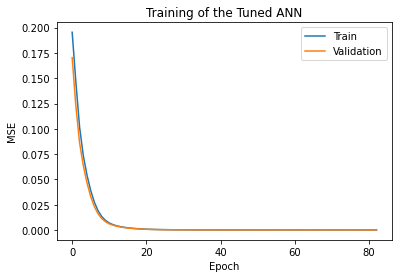

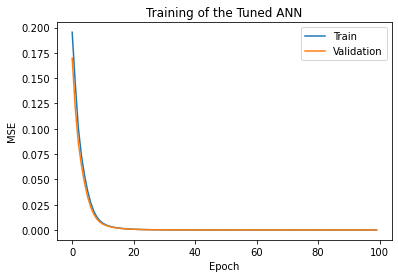

In [15]:
def visualising_data(hist, name):
    plt.title('Training of the Tuned ANN')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(name, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()
visualising_data(hypermodel_hist, '/Users/jackkelly/Desktop/Building_Model/Figures/hypermodel_results.svg')
visualising_data(history, '/Users/jackkelly/Desktop/Building_Model/Figures/full_epochs_results.svg')

In [11]:
# shows weights of the ANN
# print(hypermodel.weights)
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               5880      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               14100     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________


In [12]:
# best_hps.__dict__.keys()
# best_hps.__dict__['values']
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_' + str(N_channels) + '_channels_ANN_model.h5')

# Transfer Learning

In [19]:
def transfer_learning(model_path):
    hypermodel = keras.models.load_model(model_path)
#     hypermodel.summary()
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-06)))
#     model.summary()

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [ ]:
test_data_numbers = [200, 400, 800, 1200, 1600, 2000, 2400]
timings = []
old_model_results = []
N_channels = 40
def number_of_channels(ending):
    TL_model_results = []
    for i in range(len(test_data_numbers)):
        model = transfer_learning('Tuned_' + str(N_channels) + '_channels_ANN_model.h5')
        file_path = '/Users/jackkelly/Desktop/Building_Model/Data/' + str(test_data_numbers[i]) + '_data_points_train_val' + ending + '.csv'
        X_scale, Y_scale = processing_data(N_channels, file_path)
        X_train, X_val, Y_train, Y_val = train_test_split(X_scale, Y_scale, test_size=0.2)
        file_path = '/Users/jackkelly/Desktop/Building_Model/Data/' + str(test_data_numbers[i]) + '_data_points_test' + ending + '.csv'
        X_test, Y_test = processing_data(N_channels, file_path)
        print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
        start_time = time.time()
        # new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
        new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, shuffle=True, verbose=0)
        training_time = time.time() - start_time
        timings.append(training_time)
        # evaluating transfer-learned model
        eval_result = model.evaluate(X_test, Y_test, verbose=0)[1]
        # evaluating OLD model with new data
        hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
        TL_model_results.append(eval_result)
        old_model_results.append(hypermodel_result)
    return TL_model_results
TL_model_results_longer = number_of_channels('')
TL_model_results_shorter = number_of_channels('_shorter')
print(TL_model_results_longer)
print(TL_model_results_shorter)

In [ ]:
plt.title('Transfer Learning')
plt.plot(test_data_numbers, TL_model_results_longer, label='Network 1', marker='x', color='g')
plt.plot(test_data_numbers, TL_model_results_shorter, label='Network 2', marker='o', color='b', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Training Data Size')
plt.legend()
plt.savefig('transfer_learning.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# Creating CDF Plot

In [ ]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_blocks_20000.csv'
hist, model, X_train, Y_train, X_val, Y_val, X_test, Y_test = build_model(N_channels, file_path)

In [ ]:
# name = '/Users/jackkelly/Desktop/Building_Model/Figures/Comparison.png'
# plt.title('Comparison of new and old ANN model')
# plt.plot(hypermodel_hist.history['mean_squared_error'], label='[Trained ANN] Train')
# plt.plot(hypermodel_hist.history['val_mean_squared_error'], label='[Trained ANN] Validation')
# plt.plot(hist.history['val_mean_squared_error'], label='[Non-tuned ANN] Validation')
# plt.ylabel('MSE')
# plt.xlabel('Epoch')
# plt.legend()
# plt.savefig(name)
# plt.show()

predictions = model.predict(X_test)
# mse = mean_squared_error(predictions, Y_test)
mean_squared_error_store = []
for i in range(3000):
    mean_squared_error_store.append(mean_squared_error(predictions[i], Y_test[i]))
x = np.sort(mean_squared_error_store)
y = np.arange(1, len(x)+1) / len(x)

predictions_hyper = hypermodel.predict(X_test)
# mse = mean_squared_error(predictions, Y_test)
mean_squared_error_store_hyper = []
for i in range(3000):
    mean_squared_error_store_hyper.append(mean_squared_error(predictions_hyper[i], Y_test[i]))
x_hyper = np.sort(mean_squared_error_store_hyper)
y_hyper = np.arange(1, len(x_hyper)+1) / len(x_hyper)


# 500 elements in mseArray so 90th percentile is 450th element
print('90th percentile mse = ', x[2700],'dB')
mse_ecdf = plt.plot(x,y, marker='.', linestyle='none', color='blue', label='Non-Tuned')
mse_ecdf = plt.plot(x_hyper, y_hyper, marker='*', linestyle='none', color='green', label='Tuned')
plt.title('Cumulative Distribution Function Plot')
plt.xlabel('MSE')
plt.ylabel('CDF')
plt.legend()
plt.savefig('CDF_initial_ann.png')
plt.show()

In [16]:
best_hps.__dict__

{'_space': {'kernel_regularizer': Choice(name: "kernel_regularizer", values: [0.0001, 1e-05, 1e-06], ordered: True, default: 0.0001),
  'n_layers': Int(name: "n_layers", min_value: 1, max_value: 2, step: 1, sampling: None, default: 1),
  'hidden_0_units': Int(name: "hidden_0_units", min_value: 56, max_value: 200, step: 4, sampling: None, default: 56),
  'learning_rate': Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001], ordered: True, default: 0.01),
  'hidden_1_units': Int(name: "hidden_1_units", min_value: 56, max_value: 200, step: 4, sampling: None, default: 56)},
 'values': {'kernel_regularizer': 1e-06,
  'n_layers': 2,
  'hidden_0_units': 140,
  'learning_rate': 0.0001,
  'hidden_1_units': 100,
  'tuner/epochs': 100,
  'tuner/initial_epoch': 34,
  'tuner/bracket': 1,
  'tuner/round': 1,
  'tuner/trial_id': 'bdf75379fab0f750c95cd33384030173'},
 '_scopes': []}

# Raman Testing

In [20]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/Raman_data.csv'
df = pd.read_csv(file_path)
dataset = pd.DataFrame(df)
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/Raman_data2.csv'
df2 = pd.read_csv(file_path)
dataset2 = pd.DataFrame(df2)
file_path = '/Users/jackkelly/Desktop/Building_Model/Data_NEW/Raman_data3.csv'
df3 = pd.read_csv(file_path)
dataset3 = pd.DataFrame(df3)
df_tot = pd.concat([dataset, dataset2, dataset3],ignore_index=True)
dataset4 = df_tot.values
X = dataset4[:,0:N_channels+1]
# channel SNRs
Y = dataset4[:,N_channels+1:2*N_channels+1]
X, Y = shuffle(X, Y)
# scaling between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
Y = min_max_scaler.fit_transform(Y)

In [21]:
model = transfer_learning('Tuned_' + str(N_channels) + '_channels_ANN_model.h5')
raman_hist = model.fit(X, Y, validation_split=0.2, epochs=200, shuffle=True, verbose=2)

Train on 160 samples, validate on 40 samples
Epoch 1/200
160/160 - 1s - loss: 0.2662 - mean_squared_error: 0.2657 - val_loss: 0.2667 - val_mean_squared_error: 0.2663
Epoch 2/200
160/160 - 0s - loss: 0.2459 - mean_squared_error: 0.2454 - val_loss: 0.2448 - val_mean_squared_error: 0.2443
Epoch 3/200
160/160 - 0s - loss: 0.2272 - mean_squared_error: 0.2268 - val_loss: 0.2251 - val_mean_squared_error: 0.2247
Epoch 4/200
160/160 - 0s - loss: 0.2106 - mean_squared_error: 0.2101 - val_loss: 0.2078 - val_mean_squared_error: 0.2073
Epoch 5/200
160/160 - 0s - loss: 0.1964 - mean_squared_error: 0.1959 - val_loss: 0.1927 - val_mean_squared_error: 0.1922
Epoch 6/200
160/160 - 0s - loss: 0.1833 - mean_squared_error: 0.1828 - val_loss: 0.1800 - val_mean_squared_error: 0.1796
Epoch 7/200
160/160 - 0s - loss: 0.1723 - mean_squared_error: 0.1719 - val_loss: 0.1693 - val_mean_squared_error: 0.1689
Epoch 8/200
160/160 - 0s - loss: 0.1625 - mean_squared_error: 0.1621 - val_loss: 0.1604 - val_mean_squared_e

Epoch 68/200
160/160 - 0s - loss: 0.0139 - mean_squared_error: 0.0134 - val_loss: 0.0270 - val_mean_squared_error: 0.0265
Epoch 69/200
160/160 - 0s - loss: 0.0136 - mean_squared_error: 0.0131 - val_loss: 0.0265 - val_mean_squared_error: 0.0260
Epoch 70/200
160/160 - 0s - loss: 0.0132 - mean_squared_error: 0.0128 - val_loss: 0.0260 - val_mean_squared_error: 0.0255
Epoch 71/200
160/160 - 0s - loss: 0.0129 - mean_squared_error: 0.0125 - val_loss: 0.0255 - val_mean_squared_error: 0.0251
Epoch 72/200
160/160 - 0s - loss: 0.0126 - mean_squared_error: 0.0122 - val_loss: 0.0251 - val_mean_squared_error: 0.0246
Epoch 73/200
160/160 - 0s - loss: 0.0124 - mean_squared_error: 0.0119 - val_loss: 0.0246 - val_mean_squared_error: 0.0242
Epoch 74/200
160/160 - 0s - loss: 0.0121 - mean_squared_error: 0.0116 - val_loss: 0.0242 - val_mean_squared_error: 0.0238
Epoch 75/200
160/160 - 0s - loss: 0.0118 - mean_squared_error: 0.0114 - val_loss: 0.0238 - val_mean_squared_error: 0.0234
Epoch 76/200
160/160 - 0

Epoch 135/200
160/160 - 0s - loss: 0.0054 - mean_squared_error: 0.0050 - val_loss: 0.0126 - val_mean_squared_error: 0.0121
Epoch 136/200
160/160 - 0s - loss: 0.0054 - mean_squared_error: 0.0049 - val_loss: 0.0125 - val_mean_squared_error: 0.0120
Epoch 137/200
160/160 - 0s - loss: 0.0054 - mean_squared_error: 0.0049 - val_loss: 0.0124 - val_mean_squared_error: 0.0120
Epoch 138/200
160/160 - 0s - loss: 0.0053 - mean_squared_error: 0.0048 - val_loss: 0.0124 - val_mean_squared_error: 0.0119
Epoch 139/200
160/160 - 0s - loss: 0.0053 - mean_squared_error: 0.0048 - val_loss: 0.0123 - val_mean_squared_error: 0.0118
Epoch 140/200
160/160 - 0s - loss: 0.0052 - mean_squared_error: 0.0047 - val_loss: 0.0122 - val_mean_squared_error: 0.0117
Epoch 141/200
160/160 - 0s - loss: 0.0052 - mean_squared_error: 0.0047 - val_loss: 0.0121 - val_mean_squared_error: 0.0116
Epoch 142/200
160/160 - 0s - loss: 0.0052 - mean_squared_error: 0.0047 - val_loss: 0.0120 - val_mean_squared_error: 0.0116
Epoch 143/200
16

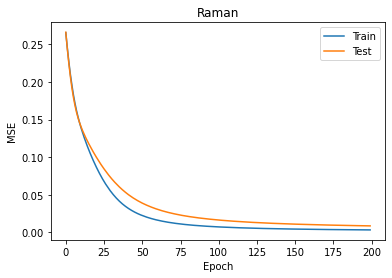

In [22]:
plt.title('Raman')
plt.plot(raman_hist.history['mean_squared_error'], label='Train')
plt.plot(raman_hist.history['val_mean_squared_error'], label='Test')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# mean_squared_error: 0.0115 - val_loss: 0.0329 - val_mean_squared_error: 0.0324
# Trainable params: 6,108, one layer: 74 nodes